**Importing Libraries**

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.9 MB/s eta 0:00:0000:010:01


In [2]:
!pip install "pystan<3.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 2.8 MB/s eta 0:00:0000:0100:01m


In [3]:
!pip install holidays==0.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 6.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: holidays
    Found existing installation: holidays 0.21.13
    Uninstalling holidays-0.21.13:
      Successfully uninstalled holidays-0.21.13


In [4]:
!pip install prophet

In [5]:
!pip install openpyxl

In [6]:
!pip install ephem

In [7]:
!pip install seaborn

In [8]:
pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 5.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.1-py3-none-any.whl size=10608 sha256=ea10db4611089913aec6d741fc0daa0eec091eb6326186ef96561f4506a1f1c4
  Stored in directory: /root/.cache/pip/wheels/e9/b8/0d/c949c0eb7a26af8926adcf3953a15dee78668f9af2261b2ac4
Successfully built MiniSom
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
import datetime
import matplotlib.dates as mdates
from cycler import cycler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import math
from tslearn.clustering import TimeSeriesKMeans
from minisom import MiniSom
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse
from scipy import signal
from scipy.stats import jarque_bera as jb
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from prophet import Prophet
import os
import warnings
warnings.filterwarnings('ignore')

**Importing Data**

In [9]:
retail_data=pd.read_csv("files/sales_train_evaluation.csv")
calender=pd.read_csv("files/calendar.csv")
sell_prices=pd.read_csv("files/sell_prices.csv")

In [10]:
rd_ca=retail_data[retail_data["state_id"]=="WI"].copy()
print("Missing Values:" +str(rd_ca.isna().sum().sum())) 
rd_ca.head(5)

Missing Values:0


id        item_id    dept_id   cat_id  \
21343  HOBBIES_1_001_WI_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
21344  HOBBIES_1_002_WI_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
21345  HOBBIES_1_003_WI_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
21346  HOBBIES_1_004_WI_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
21347  HOBBIES_1_005_WI_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  \
21343     WI_1       WI    0    0    0    0  ...       0       1       0   
21344     WI_1       WI    0    0    0    0  ...       0       1       0   
21345     WI_1       WI    0    0    0    0  ...       0       0       0   
21346     WI_1       WI    2    1    0    0  ...       0       0       0   
21347     WI_1       WI    0    0    0    0  ...       3       1       0   

       d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
21343       2       0       0       0       0       1       2  
21344       1       0       0       0       1       1       1  
21345       0       0       0       0       0       1       0  
21346       0       0       1       0       0       0       1  
21347       0       0       1       0       0       0       3  

[5 rows x 1947 columns]

In [11]:
sell_prices=sell_prices[sell_prices["store_id"].isin(["WI_1","WI_2","WI_3"])]
print("Missing Values: "+ str(sell_prices.isna().sum().sum())) 
sell_prices.head(5)

Missing Values: 0


store_id        item_id  wm_yr_wk  sell_price
4800944     WI_1  HOBBIES_1_001     11325        9.58
4800945     WI_1  HOBBIES_1_001     11326        9.58
4800946     WI_1  HOBBIES_1_001     11327        9.58
4800947     WI_1  HOBBIES_1_001     11328        9.58
4800948     WI_1  HOBBIES_1_001     11329        9.58

In [12]:
rd_ca_melted=rd_ca.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
rd_ca_melted.rename({"variable":"Day","value":"Quantity"},axis=1,inplace=True)
rd_ca_melted.head(5)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  Day  Quantity  
0       WI  d_1         0  
1       WI  d_1         0  
2       WI  d_1         0  
3       WI  d_1         2  
4       WI  d_1         0

In [13]:
ca_joined=pd.merge(calender,rd_ca_melted,how="right",left_on=("d"),right_on="Day")
ca_joined=pd.merge(ca_joined,sell_prices,how="left",on=["store_id","item_id","wm_yr_wk"])
ca_joined.head(10)

date  wm_yr_wk   weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
1  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
2  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
3  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
4  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
5  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
6  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
7  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
8  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
9  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   

  event_type_1 event_name_2  ... snap_WI                             id  \
0          NaN          NaN  ...       0  HOBBIES_1_001_WI_1_evaluation   
1          NaN          NaN  ...       0  HOBBIES_1_002_WI_1_evaluation   
2          NaN          NaN  ...       0  HOBBIES_1_003_WI_1_evaluation   
3          NaN          NaN  ...       0  HOBBIES_1_004_WI_1_evaluation   
4          NaN          NaN  ...       0  HOBBIES_1_005_WI_1_evaluation   
5          NaN          NaN  ...       0  HOBBIES_1_006_WI_1_evaluation   
6          NaN          NaN  ...       0  HOBBIES_1_007_WI_1_evaluation   
7          NaN          NaN  ...       0  HOBBIES_1_008_WI_1_evaluation   
8          NaN          NaN  ...       0  HOBBIES_1_009_WI_1_evaluation   
9          NaN          NaN  ...       0  HOBBIES_1_010_WI_1_evaluation   

         item_id    dept_id   cat_id store_id state_id  Day Quantity  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1       WI  d_1        0   
1  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1       WI  d_1        0   
2  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1       WI  d_1        0   
3  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1       WI  d_1        2   
4  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1       WI  d_1        0   
5  HOBBIES_1_006  HOBBIES_1  HOBBIES     WI_1       WI  d_1        0   
6  HOBBIES_1_007  HOBBIES_1  HOBBIES     WI_1       WI  d_1        0   
7  HOBBIES_1_008  HOBBIES_1  HOBBIES     WI_1       WI  d_1       16   
8  HOBBIES_1_009  HOBBIES_1  HOBBIES     WI_1       WI  d_1        0   
9  HOBBIES_1_010  HOBBIES_1  HOBBIES     WI_1       WI  d_1        1   

  sell_price  
0        NaN  
1        NaN  
2        NaN  
3       4.34  
4        NaN  
5        NaN  
6        NaN  
7       0.46  
8        NaN  
9       3.17  

[10 rows x 23 columns]

In [14]:
ca_joined.drop(["snap_CA","snap_TX"],axis=1,inplace=True)
ca_joined["total_sales"]=ca_joined["Quantity"]*ca_joined["sell_price"]

In [15]:
CA_store_daily=ca_joined.groupby(["store_id","date"],as_index=False).agg(Total_sales=("total_sales","sum"))
CA_store_daily["date"]=pd.to_datetime(CA_store_daily["date"])
CA_combined=CA_store_daily.pivot(index="date",columns="store_id",values="Total_sales")
CA1,CA2,CA3=[CA_store_daily[CA_store_daily["store_id"]==i].copy() for i in ["WI_1","WI_2","WI_3"]]
CA1.info()
CA_combined.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 1941 entries, 0 to 1940

Data columns (total 3 columns):

 #   Column       Non-Null Count  Dtype         

---  ------       --------------  -----         

 0   store_id     1941 non-null   object        

 1   date         1941 non-null   datetime64[ns]

 2   Total_sales  1941 non-null   float64       

dtypes: datetime64[ns](1), float64(1), object(1)

memory usage: 60.7+ KB

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22

Data columns (total 3 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   WI_1    1941 non-null   float64

 1   WI_2    1941 non-null   float64

 2   WI_3    1941 non-null   float64

dtypes: float64(3)

memory usage: 60.7 KB


In [16]:
for i in [CA1,CA2,CA3]:
    i.set_index("date",inplace=True)
    i.index.freq="D"

**Calculating Monthly sales for all stores.**

In [17]:
CA_monthly=CA_combined.resample("MS").sum()
CA_monthly_ind=[]
for i in [CA1,CA2,CA3]:
    CA_monthly_ind.append(i["Total_sales"].resample("MS").sum())
CA_monthly_long=CA_store_daily.set_index("date").groupby(["store_id"])["Total_sales"].resample("MS").sum().reset_index()

Text(0.5, 1.0, 'Monthly Sale From Jan-2011 to May-2016')

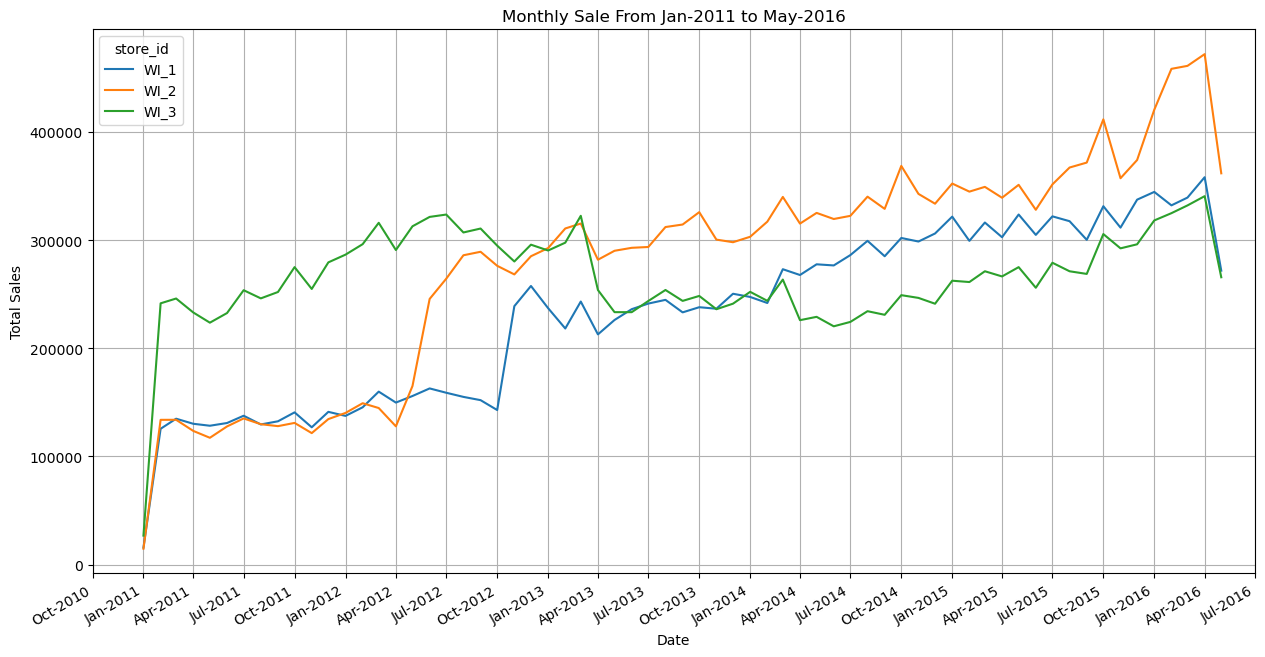

In [18]:
CA_monthly.plot(legend=True,
                figsize=(15,8),
                xlim=[datetime.datetime(2010,10,1),datetime.datetime(2016,7,1)],
                grid=True,
                ylabel="Total Sales",
                xlabel="Date",
                x_compat=True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_title("Monthly Sale From Jan-2011 to May-2016")

In [19]:
for i in range(3):
    CA_monthly_ind[i]=CA_monthly_ind[i].loc["02-2011":"04-2016"].copy()
CA_monthly=CA_monthly.loc["02-2011":"04-2016"].copy()
CA_monthly_long=CA_monthly_long.set_index("date").loc["02-2011":"04-2016"]

In [20]:
CA_monthly.to_excel("CA__monthly.xlsx")
for j,i in enumerate(CA_monthly_ind):
    i.to_excel("CA_"+str(j+1)+".xlsx")
CA_monthly_long.to_excel("CA__monthly_long.xlsx")

In [21]:
print("Length of the full dataset:"+str(len(CA_monthly.index.unique())))

Length of the full dataset:63


In [19]:
inputExcelFile ="files/CA_1.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("files/CA_1.csv", index = None, header=True)

In [20]:
inputExcelFile ="files/CA_2.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("files/CA_2.csv", index = None, header=True)

In [21]:
inputExcelFile ="files/CA_3.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("files/CA_3.csv", index = None, header=True)

In [22]:
directory = "/kaggle/working/"

mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(directory+filename)
        df = df.loc[:,["date","Total_sales"]]
        df.set_index("date",inplace=True)
        df.sort_index(inplace=True)
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

In [23]:
print(len(mySeries))

3


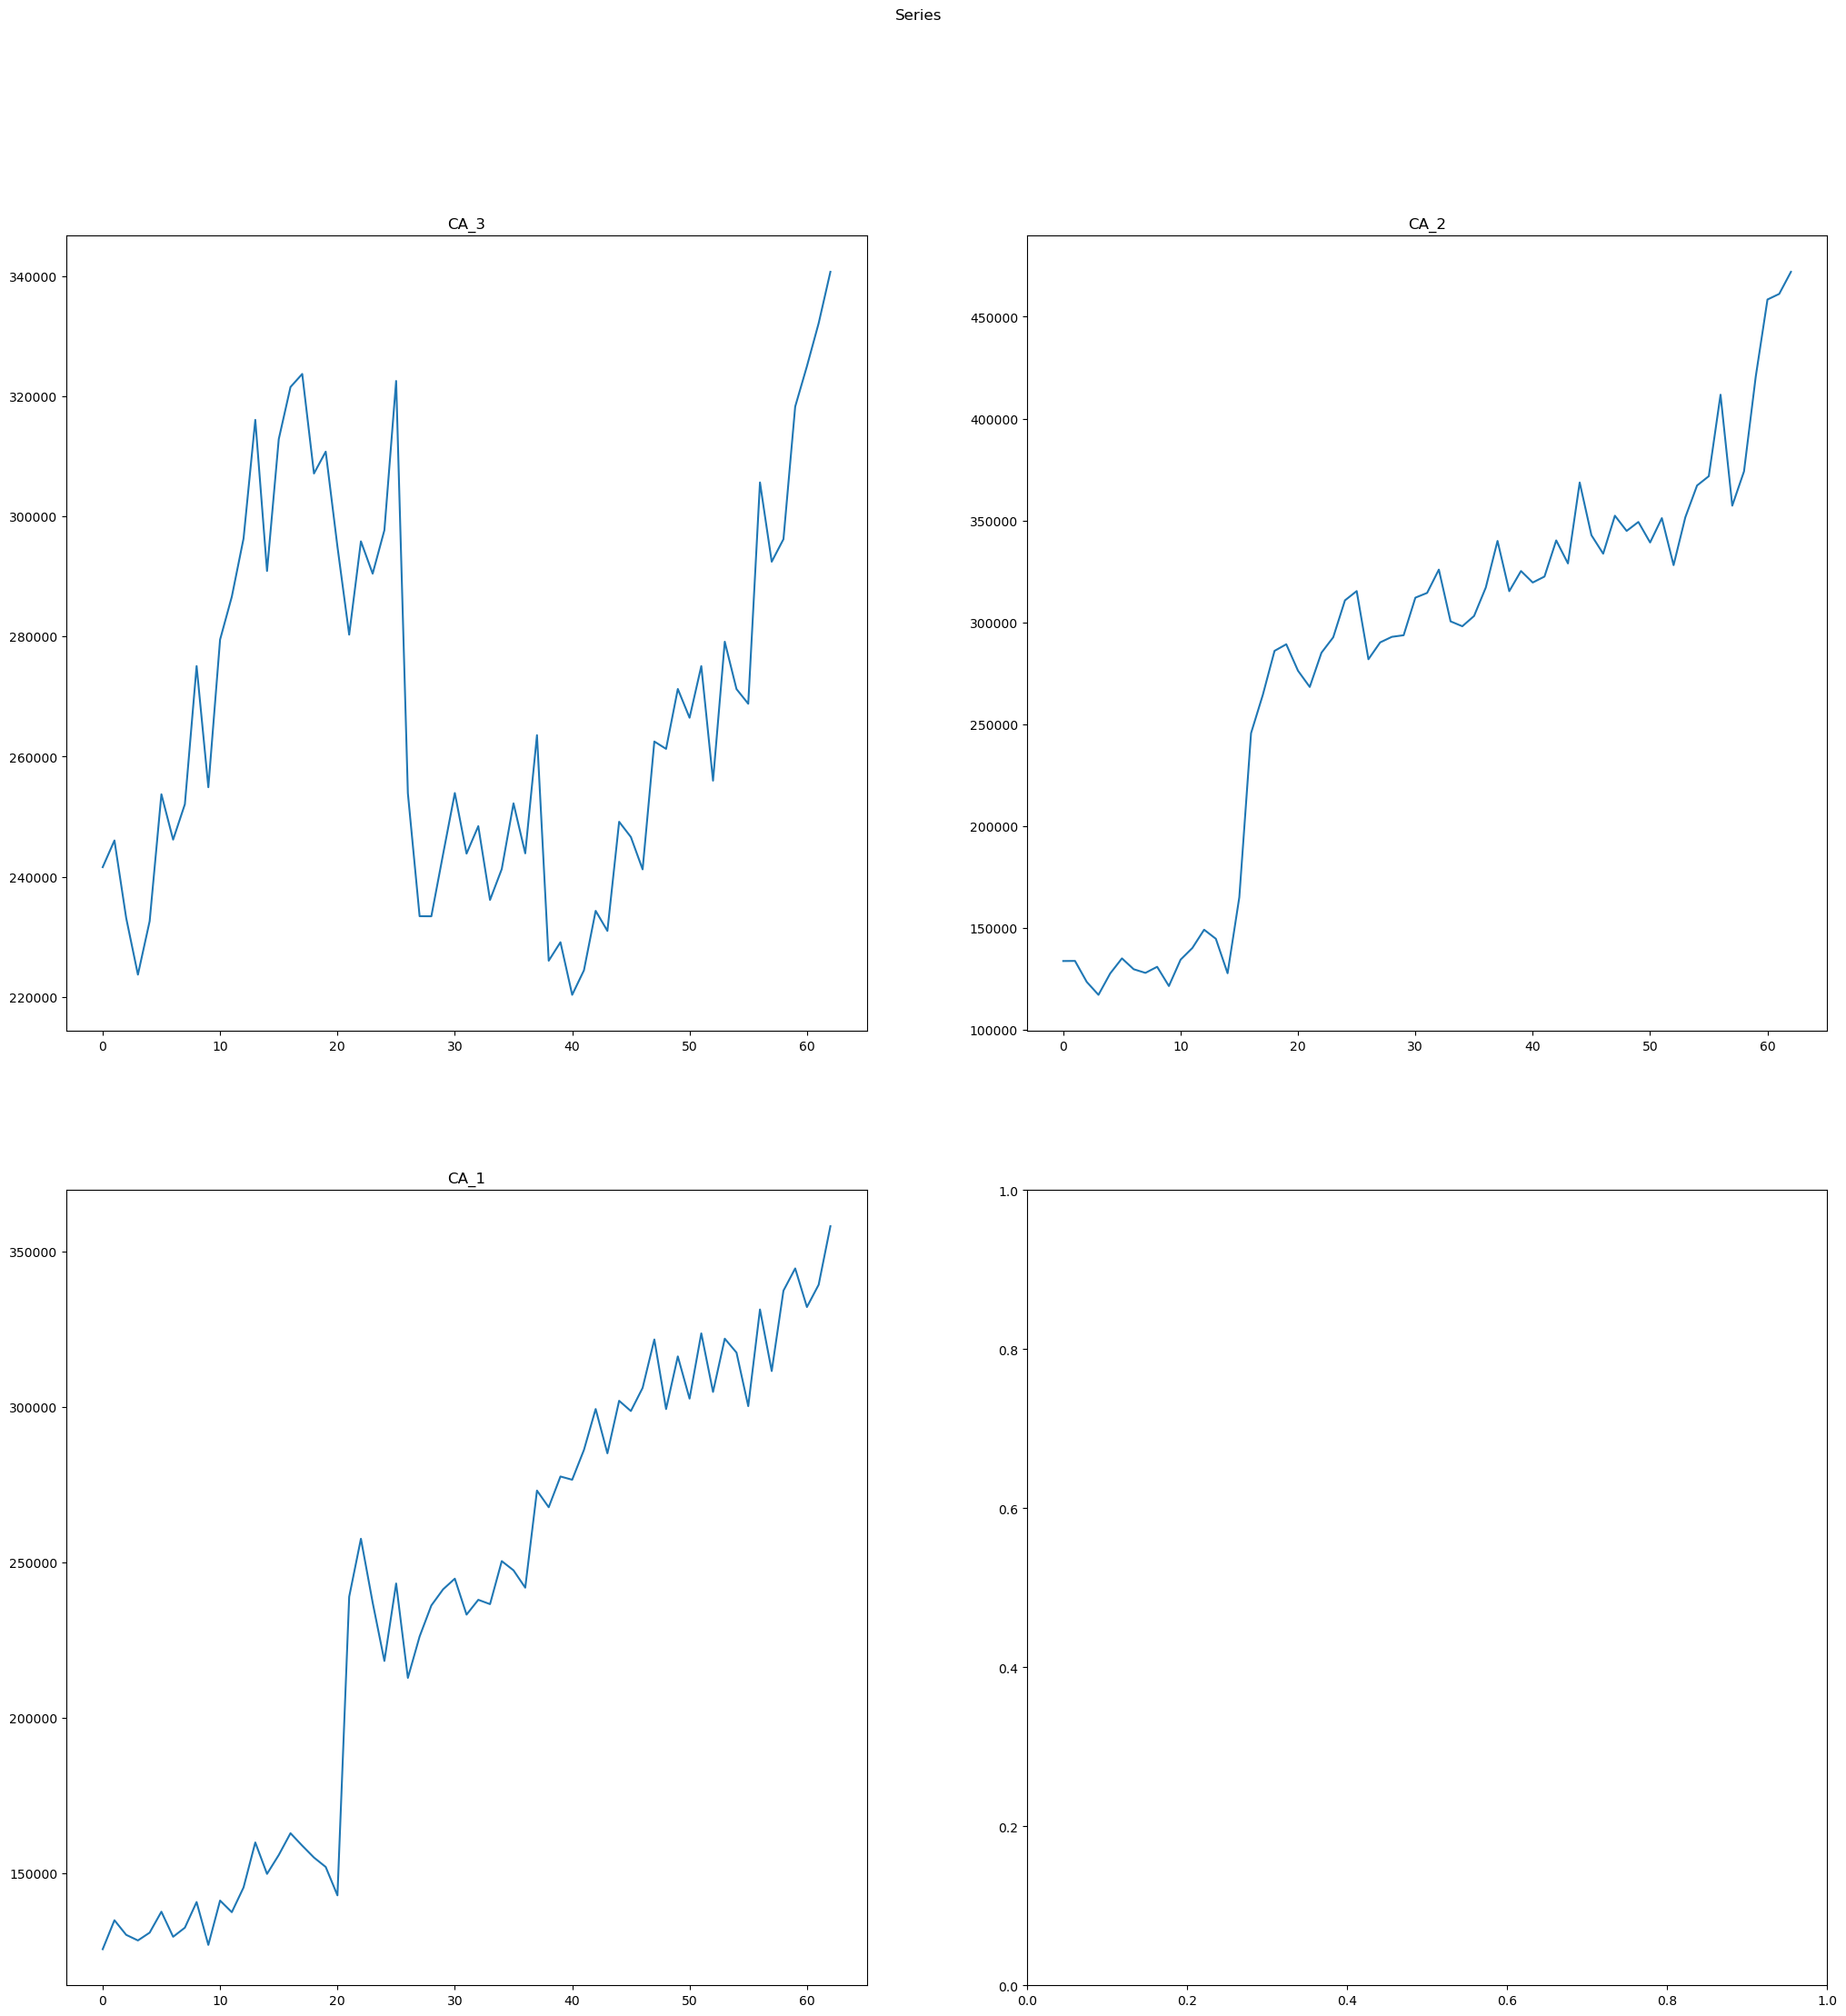

In [24]:
fig, axs = plt.subplots(2,2,figsize=(25,25))
fig.suptitle('Series')
for i in range(2):
    for j in range(2):
        if i*2+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*2+j].values)
        axs[i, j].set_title(namesofMySeries[i*2+j])
plt.show()

In [26]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{63}


In [27]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [28]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.17660691 0.2135212  0.1062688  0.02792117 0.10192077]


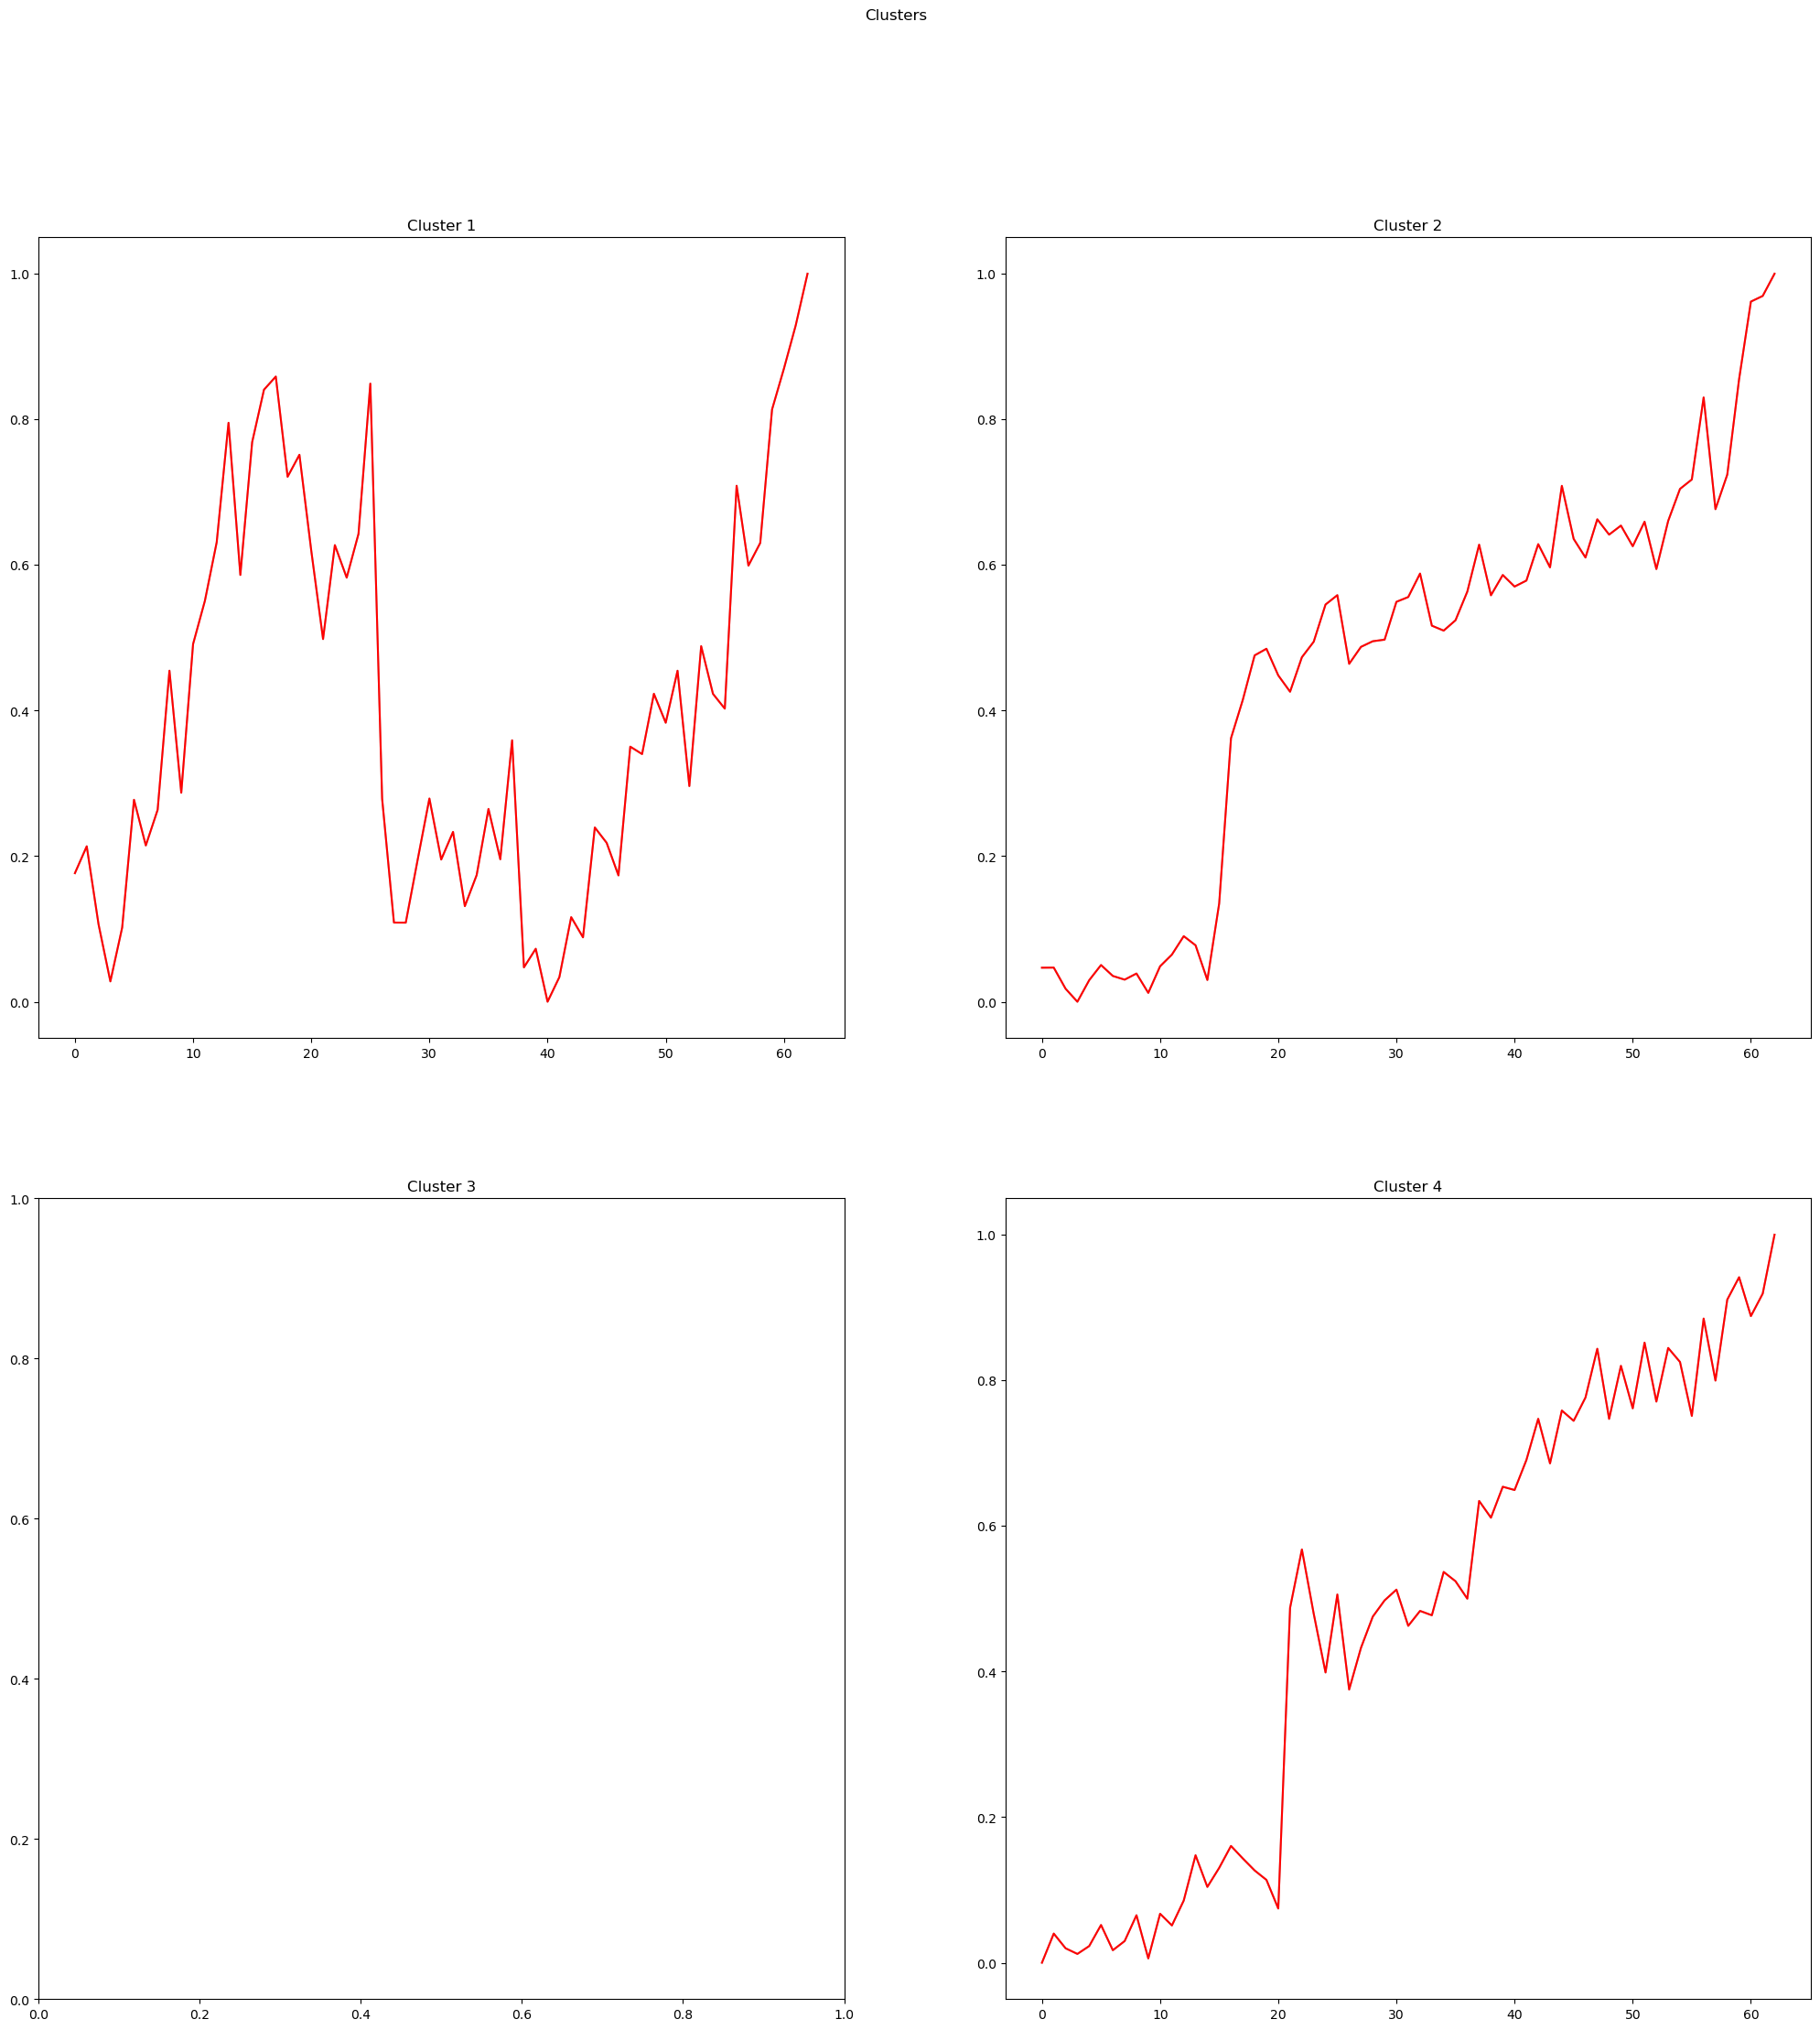

(0, 0)
(0, 1)
(1, 1)


Cluster
Series           
CA_3    Cluster 1
CA_2    Cluster 2
CA_1    Cluster 4

In [29]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

win_map = som.win_map(mySeries)

plot_som_series_averaged_center(som_x, som_y, win_map)

for series in mySeries[:5]:
    print(som.winner(series))

cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

K Means clustering

In [30]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

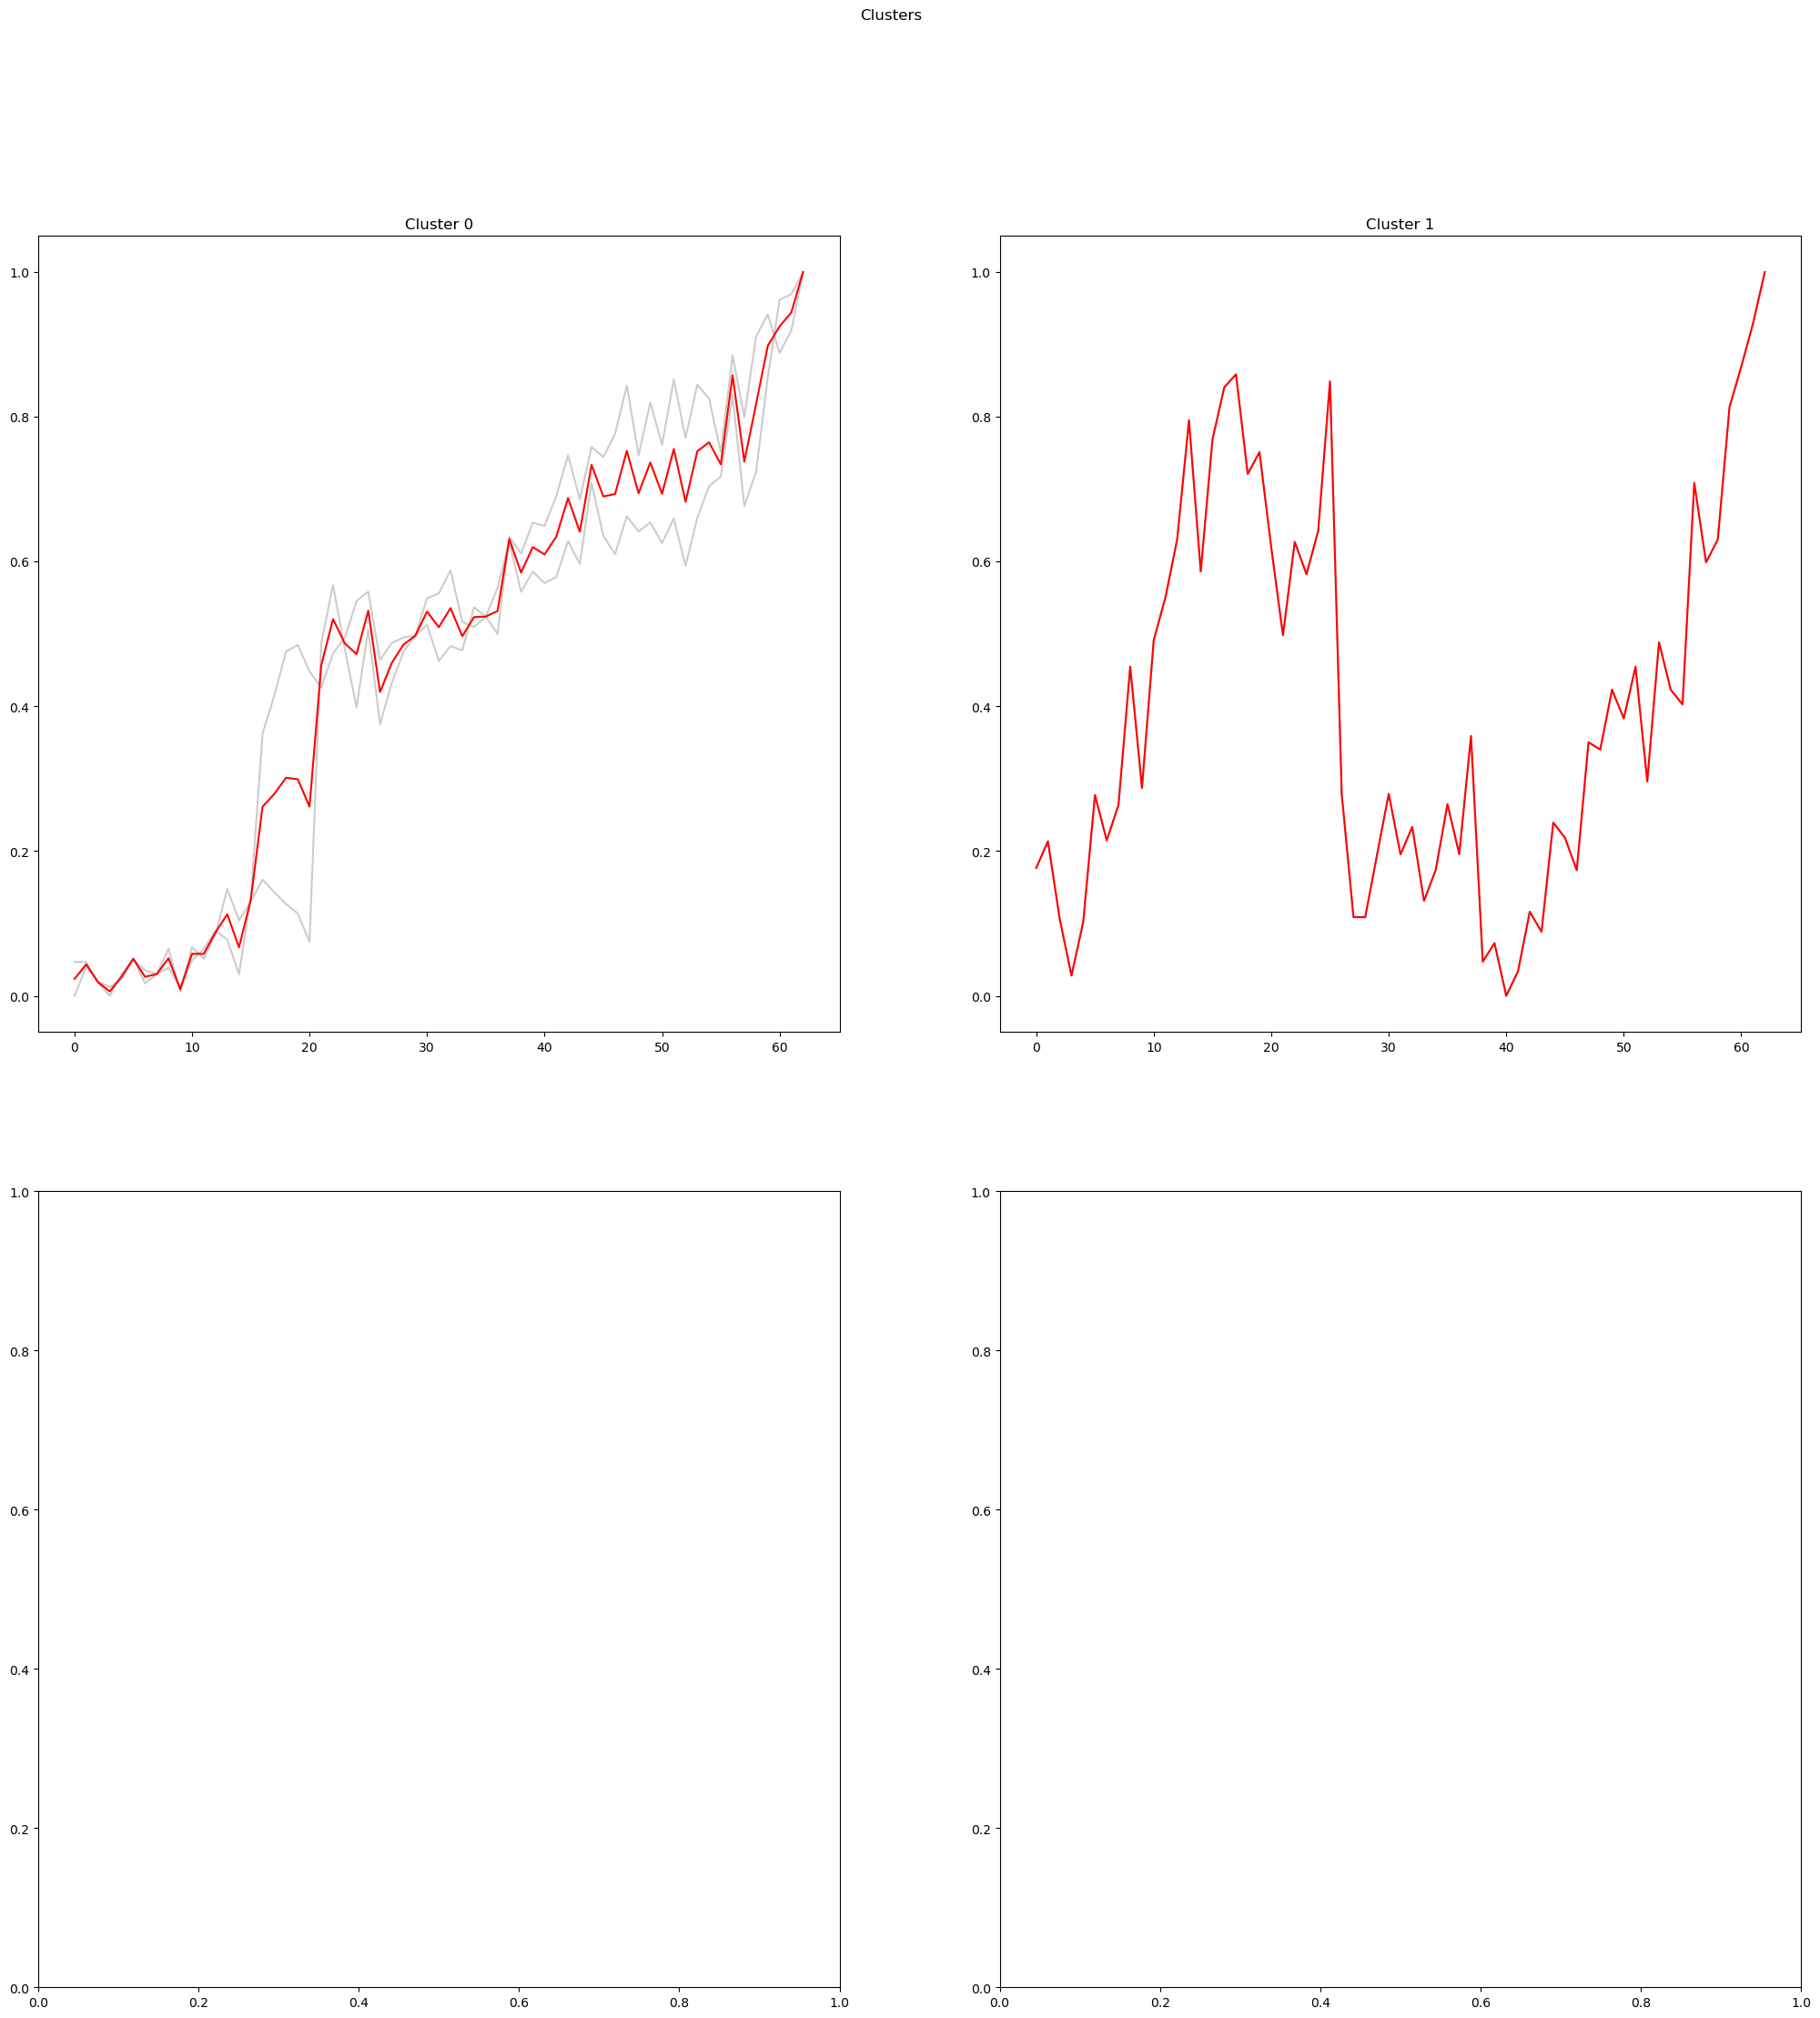

In [31]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [32]:
labels

array([1, 0, 0])

In [33]:
names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series           
CA_2    Cluster 0
CA_1    Cluster 0
CA_3    Cluster 1

### Train Test Split

In [22]:
CA_monthly_ind=[]
CA_monthly=pd.read_excel("files/CA__monthly.xlsx",parse_dates=True).set_index("date")
CA_monthly.index.freq="MS"
CA1=pd.read_excel("files/CA_1.xlsx",parse_dates=True).set_index("date")
CA2=pd.read_excel("files/CA_2.xlsx",parse_dates=True).set_index("date")
CA3=pd.read_excel("files/CA_3.xlsx",parse_dates=True).set_index("date")
CA_monthly_long=pd.read_excel("files/CA__monthly_long.xlsx",parse_dates=True).set_index("date")
for i in [CA1,CA2,CA3]:
    CA_monthly_ind.append(i["Total_sales"])

In [23]:
Train=CA_monthly[:-9]
Test=CA_monthly[-9:]
Train_ind=[i[:-9] for i in CA_monthly_ind]
Test_ind=[i[-9:] for i in CA_monthly_ind]
Train_long=CA_monthly_long.loc["02-2011":"07-2015"]
Test_long=CA_monthly_long.loc["08-2015":]

### Exploratory Data Analysis

#### Rolling Mean and Sales 

IndexError: list index out of range

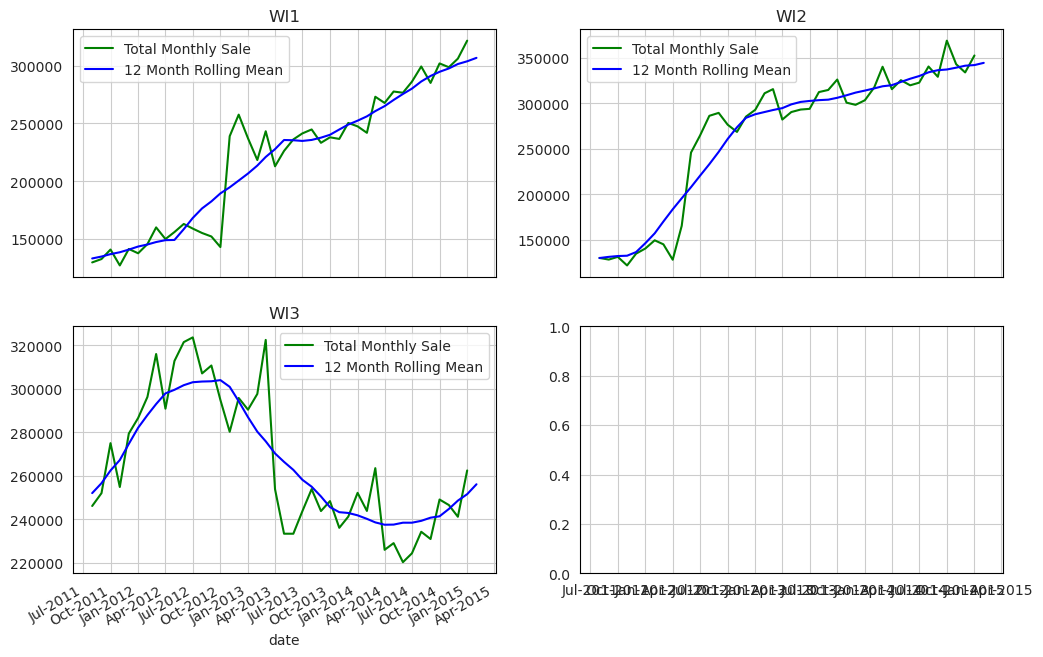

In [27]:
sns.set_style("whitegrid",{"axes.edgecolor": "black"})
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=2,sharex=True)
k=0;
for i in range(2):
    for y in range(2):
        Train_ind[k][6:-6].plot(legend=True,label="Total Monthly Sale",color="green",ax=axes[i][y],grid=True,x_compat=True,title="WI"+str(k+1))
        Train_ind[k].rolling(12,center=True).mean().plot(legend=True,color="blue",label="12 Month Rolling Mean",ax=axes[i][y],grid=True,x_compat=True)
        axes[i][y].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        axes[i][y].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
        k=k+1
fig.suptitle("Monthly Sale And Rolling Mean")

IndexError: list index out of range

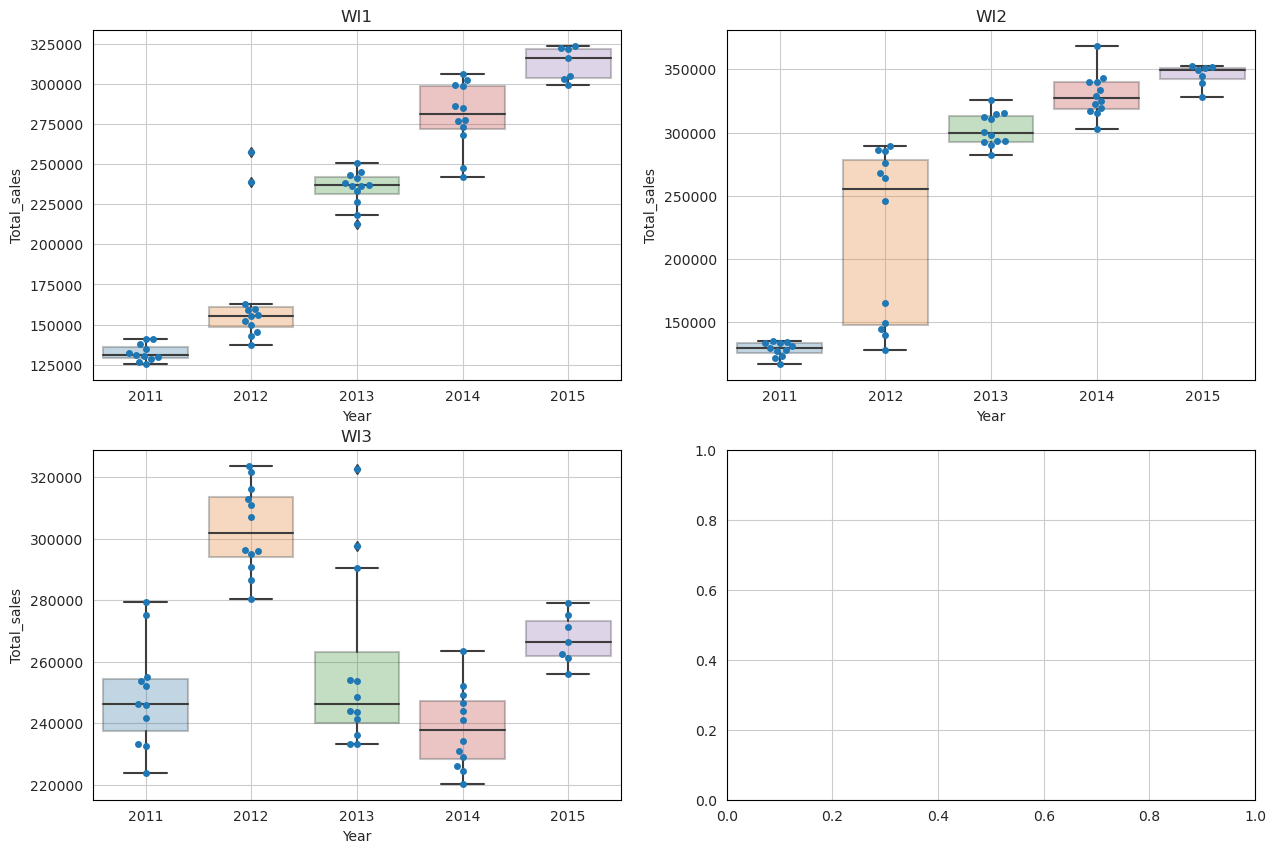

In [28]:
fig, ax = plt.subplots(figsize = (15,10),nrows=2,ncols=2)
for i in range(4):
    sns.boxplot(x=Train_ind[i].index.year.tolist(),y=Train_ind[i] ,ax=ax[int(i/2)][i%2], boxprops=dict(alpha=.3));
    sns.swarmplot(y=Train_ind[i],ax=ax[int(i/2)][i%2] ,x=Train_ind[i].index.year.tolist())
    ax[int(i/2)][i%2].set_title("WI"+str(i+1))
    ax[int(i/2)][i%2].grid(True)
    ax[int(i/2)][i%2].set_xlabel("Year")
fig.suptitle("Box-Plot")
fig.tight_layout()

#### Monthly trends & distrbution

**Monthly Subseries Plot**

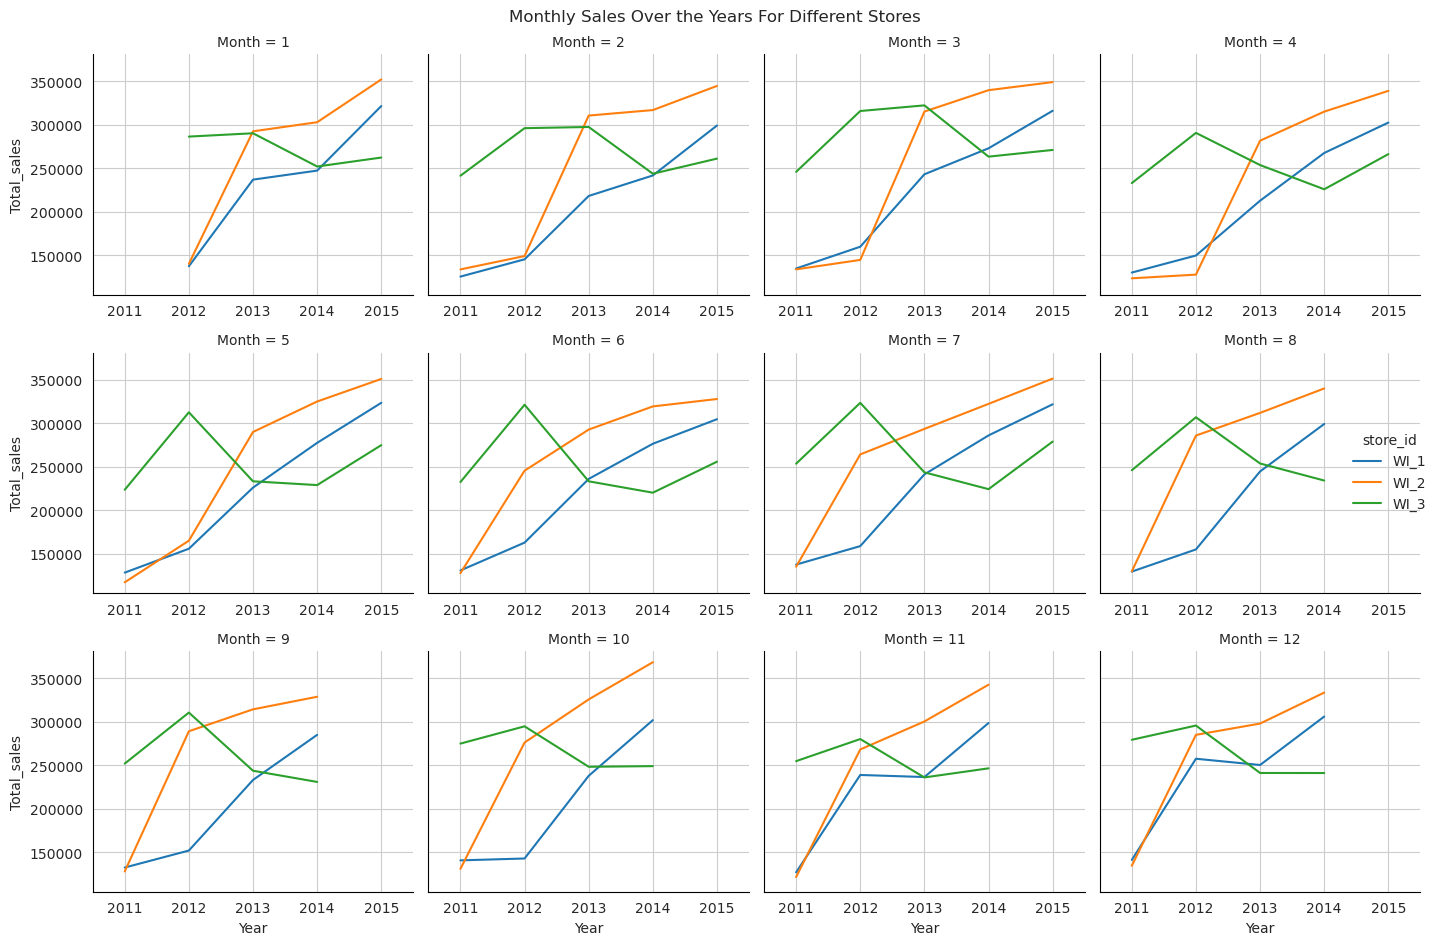

In [29]:
Train_ss=Train_long.copy()
Train_ss["Year"]=Train_ss.index.year.tolist()
Train_ss["Month"]=Train_ss.index.month.tolist()
fg_grid=sns.relplot(data=Train_ss.reset_index(),
                x="Year",
                hue="store_id",
                y="Total_sales",
                col="Month",
                kind="line",
                col_wrap=4,
                height=3.2,
                aspect=1.06,
                facet_kws={"sharex":False,"xlim":(2010.5,2015.5),"sharey":True}
).figure.suptitle("Monthly Sales Over the Years For Different Stores")
fg_grid.figure.tight_layout()

**Distribution Plot**

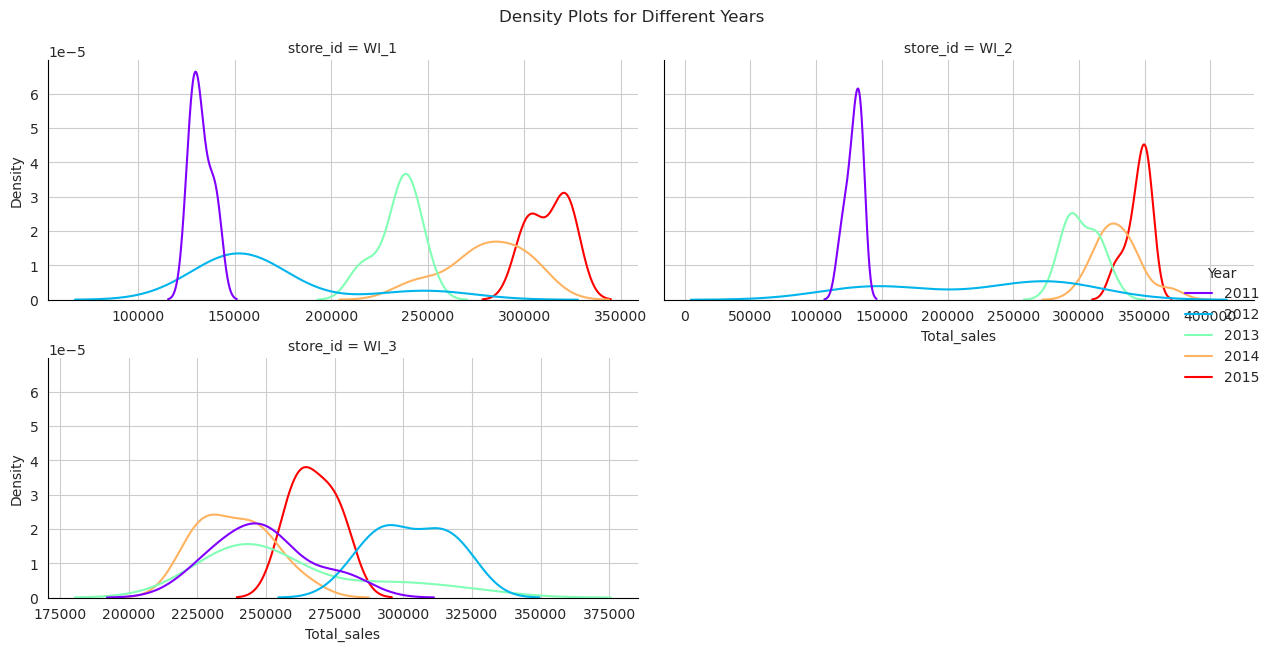

In [30]:
fg_grid=sns.displot(data=Train_ss.reset_index(),
            x="Total_sales",
            kind="kde",
            col="store_id",
            col_wrap=2,
            palette="rainbow",
            hue="Year",
            legend=True,
            facet_kws={"sharex":False},
            height=3.3,
            aspect=1.8,
            common_norm=False).figure.suptitle("Density Plots for Different Years") 
fg_grid.figure.tight_layout()

**Heat-Map**

KeyError: 'WI_4'

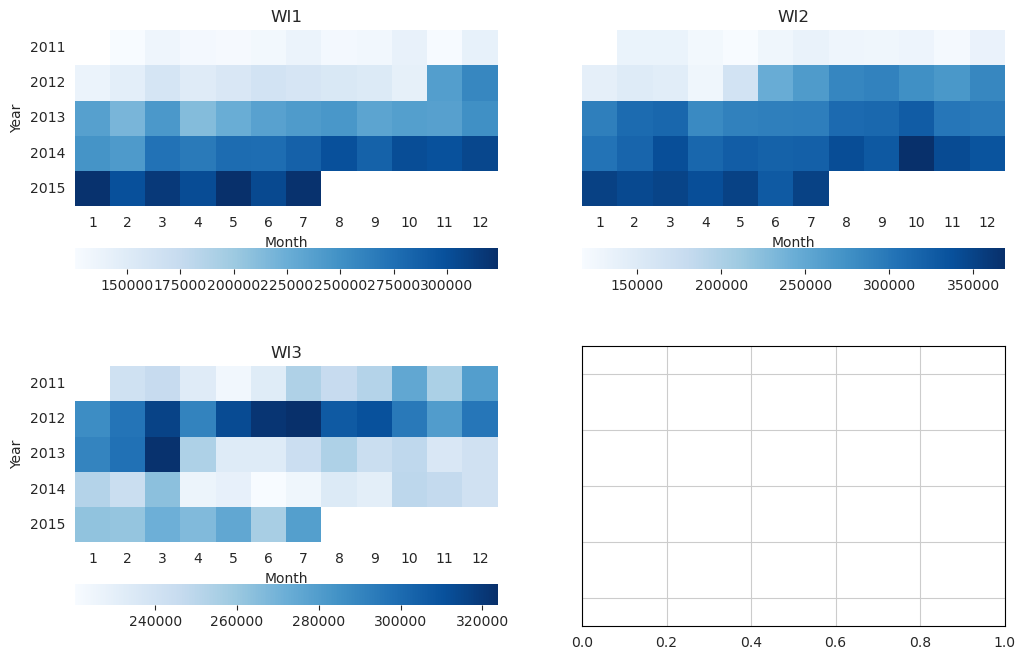

In [32]:
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=2,sharey=True)
p=pd.pivot_table(data=Train_ss[["store_id","Total_sales","Month","Year"]], 
                 index=["store_id","Year"],
                 columns="Month",
                 values="Total_sales")
k=0;
for i in range(2):
    for y in range(2):
        k=k+1
        t=sns.heatmap(p.loc["WI_"+str(k)],
                    square=True,
                    cmap='Blues',
                    ax=axes[i][y],
                    cbar=True,
                    cbar_kws={"orientation":"horizontal"});
        axes[i][y].set_title("WI"+str(k))
        axes[i][y].tick_params('y', labelrotation=0) 
        if y==1: axes[i][y].set_ylabel(None) 
# mappable = t.get_children()[0]
# plt.colorbar(mappable, ax =[axes[2][0],axes[2][1]],use_gridspec=True,orientation = 'horizontal')
fig.suptitle("Heat-Map")
fig.tight_layout()

**Stacked Bar Graph-Each Month Share in Total Sales**

KeyError: 'WI_4'

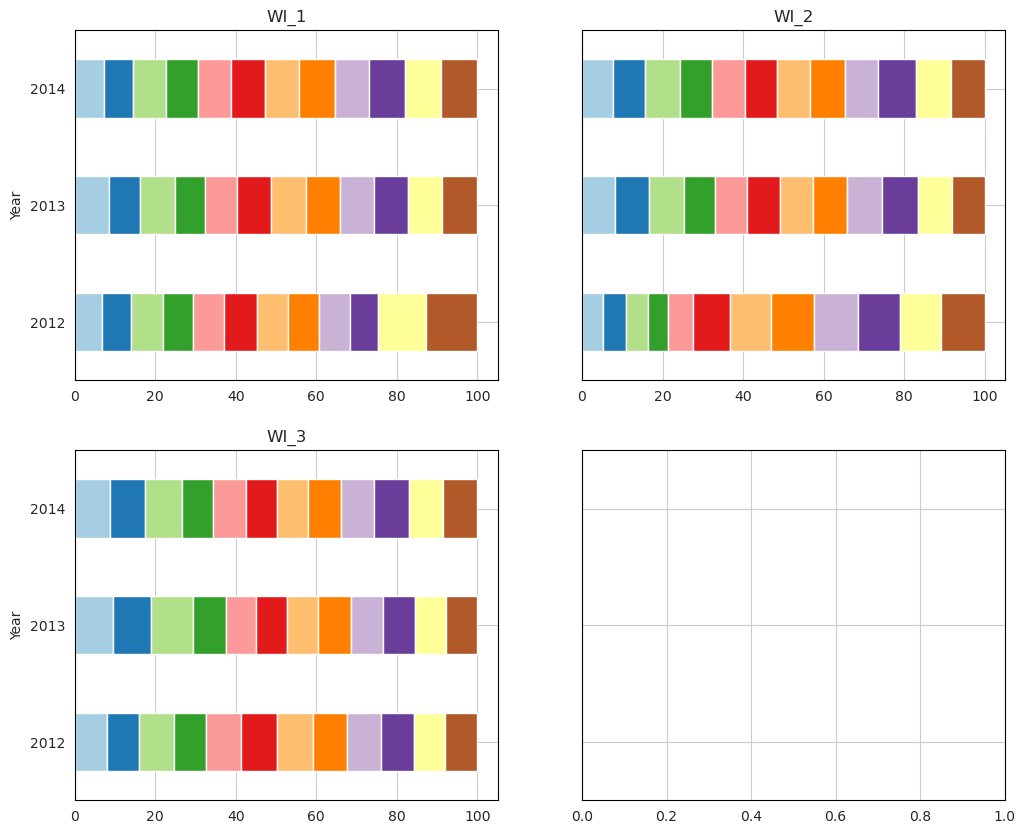

In [33]:
fig,ax=plt.subplots(figsize=(12,10),nrows=2,ncols=2,sharey=True)
for j in range(4): 
        sum_of_years=p.loc["WI_"+str(j+1)].loc[2012:2014].sum(axis=1)
        p_percentage=p.loc["WI_"+str(j+1)].loc[2012:2014].divide(sum_of_years,axis=0)*100
        p_percentage.plot(kind='barh', stacked=True, title="WI_"+str(j+1),ax=ax[int(j/2)][j%2],legend=False,colormap="Paired")
handles, labels = ax[0][0].get_legend_handles_labels()
fig.suptitle("Percentage of Sales in Individual Months for Different Years")
fig.legend(handles, labels,bbox_to_anchor=(0.97,0.6),title="Month")
plt.show()

### Decomposition

1. **WI1**

[None, None]

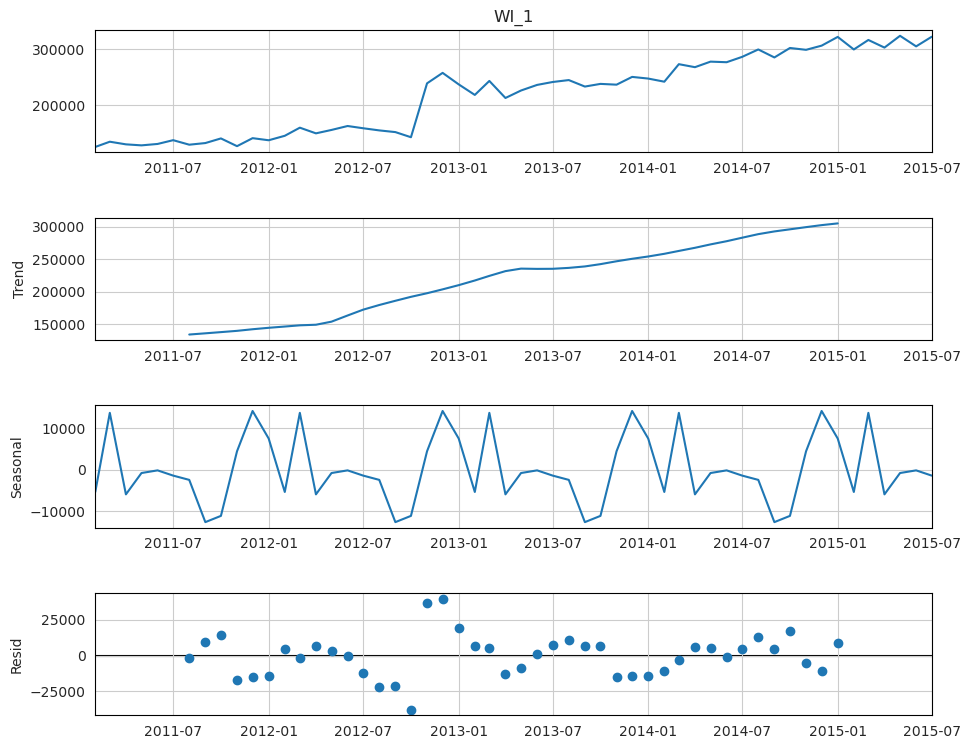

In [34]:
decompose_CA1 = seasonal_decompose(Train["WI_1"])
decompose_CA1.plot().set(figheight=8.1,figwidth=10.8)

In [35]:
ljung_p=np.mean(ljung(decompose_CA1.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

p-value : 0.0019425021081619683 

Since p < 0.05 = True, The residuals are uncorelated


2. **WI2**

[None, None]

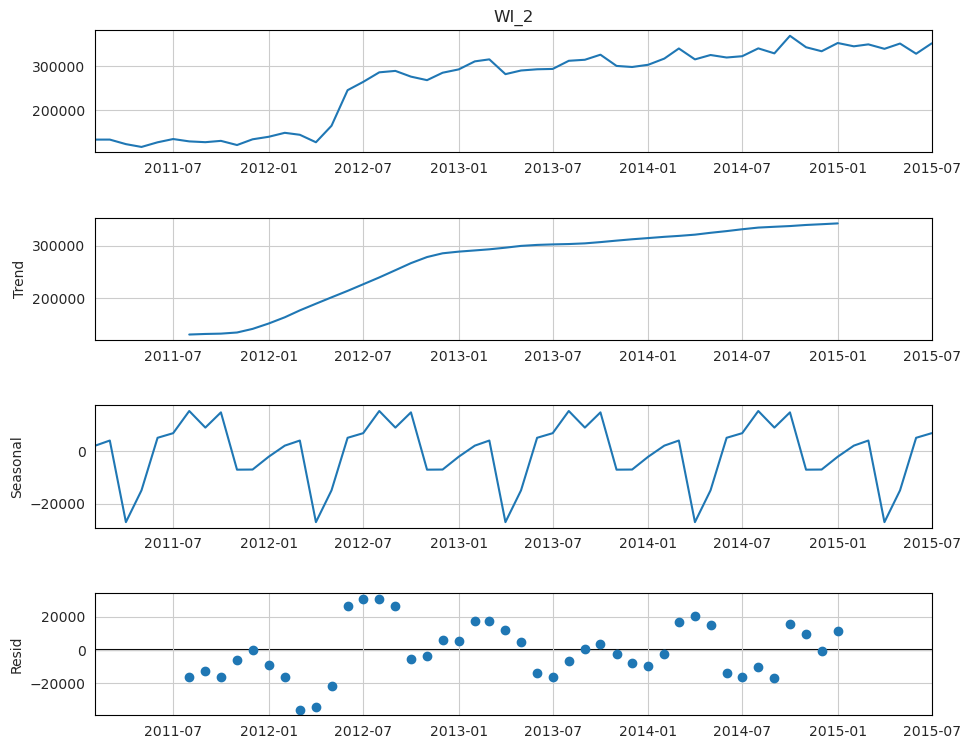

In [36]:
decompose_CA2 = seasonal_decompose(Train["WI_2"])
decompose_CA2.plot().set(figheight=8.1,figwidth=10.8)

In [37]:
ljung_p=np.mean(ljung(decompose_CA2.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

p-value : 1.2809290818114237e-05 

Since p < 0.05 = True, The residuals are uncorelated


3. **WI3**

[None, None]

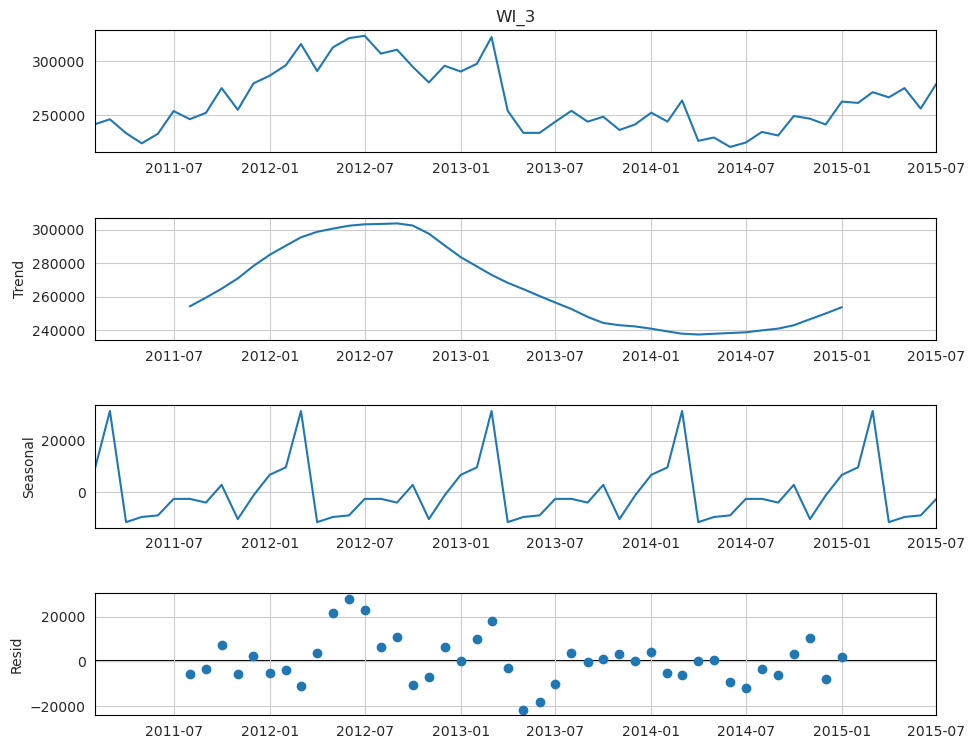

In [38]:
decompose_CA3 = seasonal_decompose(Train["WI_3"])
decompose_CA3.plot().set(figheight=8.1,figwidth=10.8)

In [39]:
ljung_p=np.mean(ljung(decompose_CA3.resid.dropna(),lags=24,return_df=True)["lb_pvalue"])
print("p-value :",ljung_p, "\nSince p < 0.05 =",str(ljung_p<0.05)+","
                     ,"The residuals are uncorelated" if ljung_p<0.05 else "The resisuals are co-related")

p-value : 0.004899486744097731 

Since p < 0.05 = True, The residuals are uncorelated


### Stationarity


1. **WI1**

Standard Deviation: 68139.68210627997


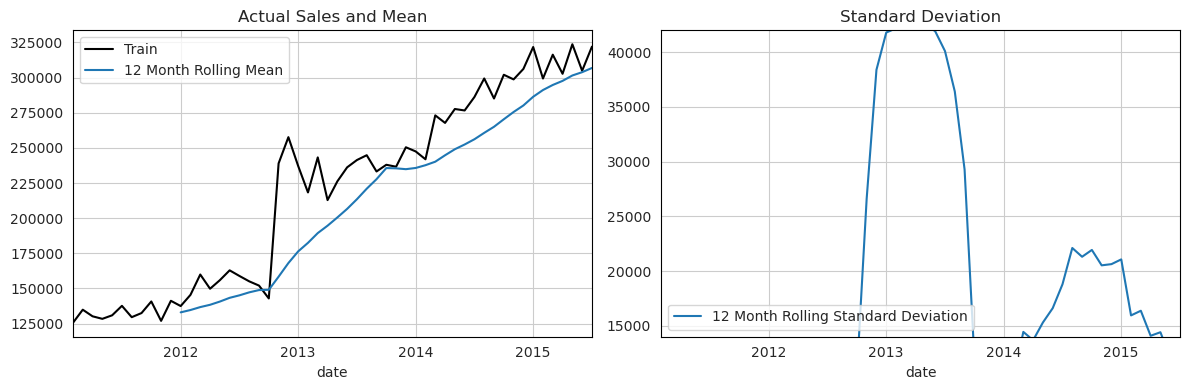

In [40]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["WI_1"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["WI_1"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["WI_1"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",ylim=(14000,42000),label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["WI_1"].std())

In [41]:
print("Coefficient of Variation:",Train["WI_1"].std()/Train["WI_1"].mean())

Coefficient of Variation: 0.3105831643461625


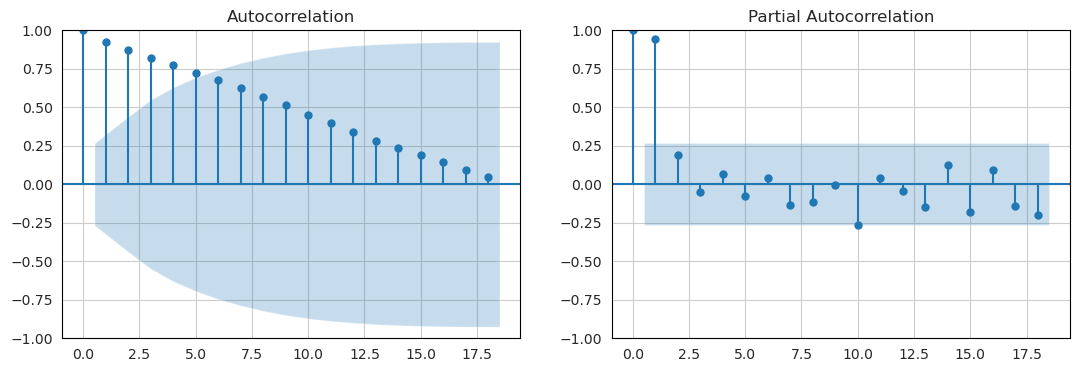

In [42]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["WI_1"],ax=ax1[0]);
plot_pacf(Train["WI_1"],ax=ax1[1]);

In [43]:
adf = adfuller(Train["WI_1"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.8698 , Series is Non-Stationary


In [44]:
adf2 = adfuller(Train["WI_1"].diff(1).dropna())[1]
print(f"p value:{adf2.round(4)}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
adf2 = adfuller(Train["WI_1"].diff(1).diff(1).dropna())[1]
print(f"p value:{adf2.round(4)}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")

p value:0.0 , Series is Stationary

p value:0.0 , Series is Stationary


2. **WI2**

Standard Deviation: 86348.49105763416


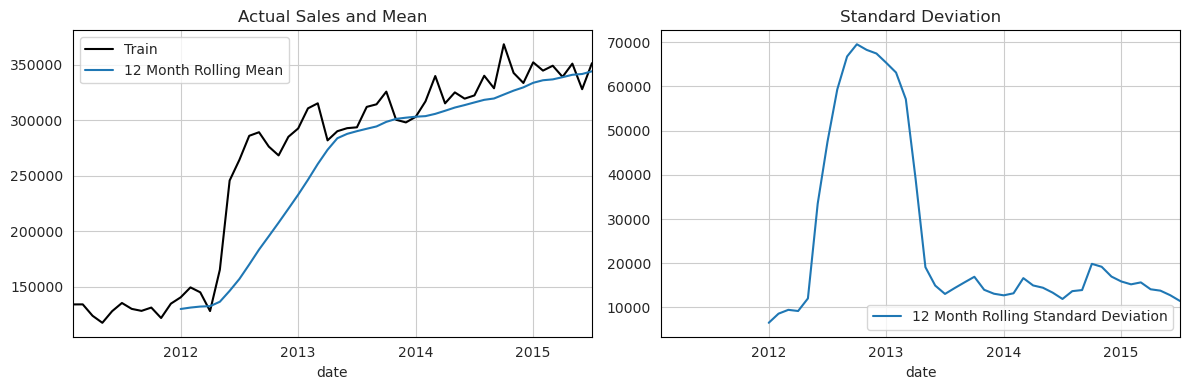

In [45]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["WI_2"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["WI_2"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["WI_2"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["WI_2"].std())

In [46]:
print("Coefficient of Variation:",Train["WI_2"].std()/Train["WI_1"].mean())

Coefficient of Variation: 0.39357958182673514


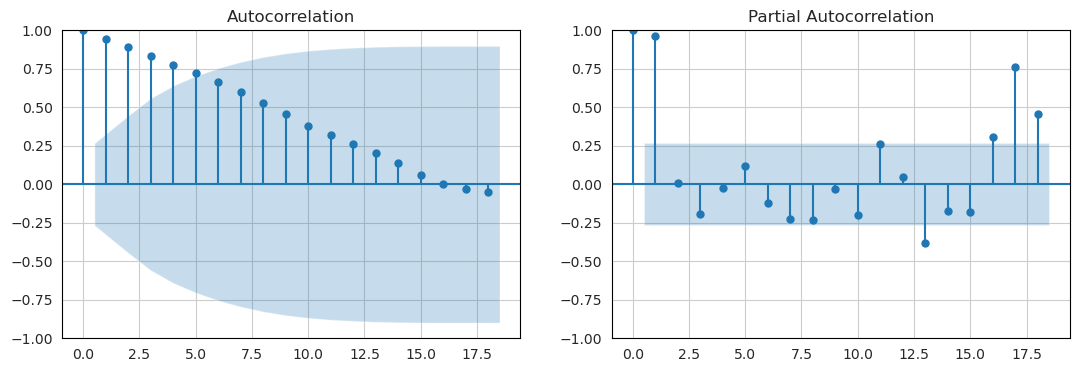

In [47]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["WI_2"],ax=ax1[0]);
plot_pacf(Train["WI_2"],ax=ax1[1]);

In [48]:
adf = adfuller(Train["WI_2"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.7067 , Series is Non-Stationary


2. **WI3**

Standard Deviation: 29374.84854311897


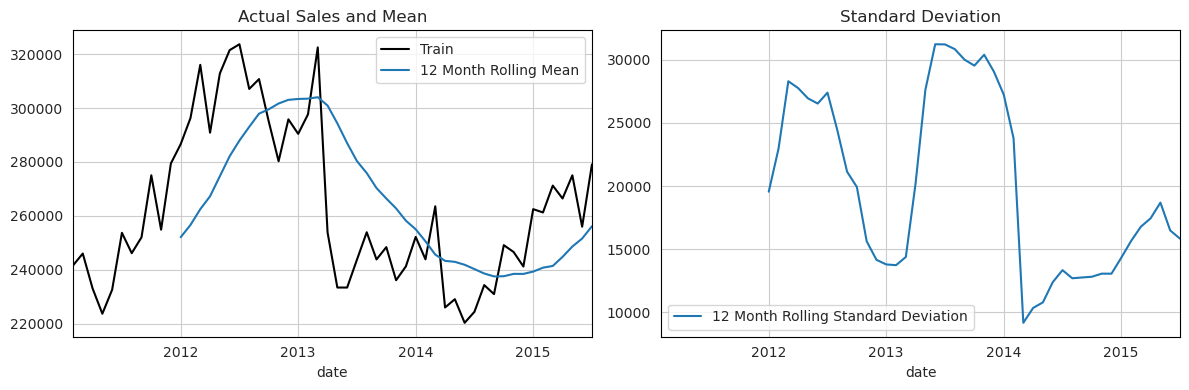

In [49]:
fig,ax1=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
Train["WI_3"].plot(ax=ax1[0],legend=True,label="Train",cmap="gray",title="Actual Sales and Mean")
Train["WI_3"].rolling(12,center=False).mean().plot(legend=True,ax=ax1[0],label="12 Month Rolling Mean")
Train["WI_3"].rolling(12,center=False).std().plot(ax=ax1[1],title="Standard Deviation",label="12 Month Rolling Standard Deviation",legend=True)
fig.tight_layout()
print("Standard Deviation:",Train["WI_3"].std())

In [50]:
print("Coefficient of Variation:",Train["WI_3"].std()/Train["WI_3"].mean())

Coefficient of Variation: 0.11164936452935902


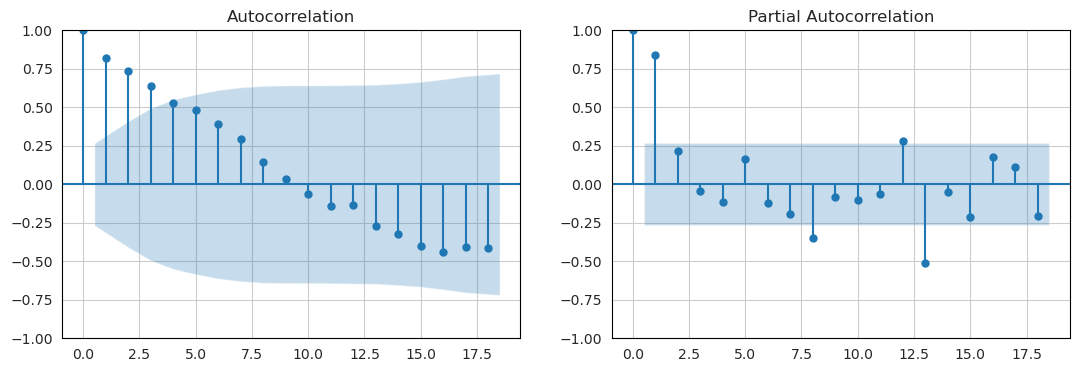

In [51]:
fig,ax1=plt.subplots(figsize=(13,4),nrows=1,ncols=2)
plot_acf(Train["WI_3"],ax=ax1[0]);
plot_pacf(Train["WI_3"],ax=ax1[1]);

In [52]:
adf = adfuller(Train["WI_3"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")


p value:0.1998 , Series is Non-Stationary


**Distribution Plot**

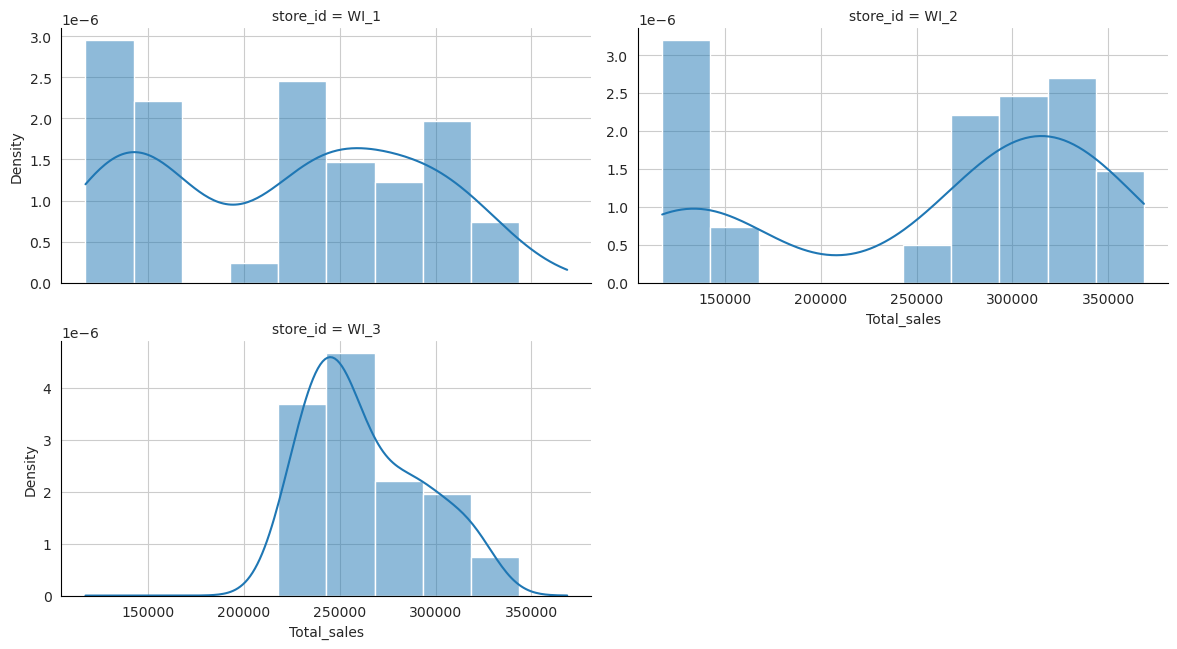

In [53]:
fg_obj=sns.displot(data=Train_ss[["store_id","Total_sales"]].reset_index(),
            x="Total_sales",
            kind="hist",
            col="store_id",
            col_wrap=2,
            facet_kws={"sharex":True,"sharey":False},
            kde=True,
            stat="density",
            legend=True,
            height=3.3,
            aspect=1.8).tight_layout()

In [54]:
is_norm=pd.DataFrame(columns=["store_id","jb_p_value","Distribution"])
for i in ["WI_1","WI_2","WI_3"]:
    p_value=jb(Train[i])[1]
    is_norm=pd.concat([is_norm,
               pd.DataFrame([{"store_id":i,
                              "jb_p_value":p_value,
                              "Distribution":"Normal" if p_value>0.05 else "Not Normal"}]
                           )],
               ignore_index=True)
is_norm

store_id  jb_p_value Distribution
0     WI_1    0.081252       Normal
1     WI_2    0.023037   Not Normal
2     WI_3    0.110480       Normal

## Model Fitting and Selection

In [55]:
def MAPE(y_true,y_pred):
    ytrue,ypred=np.array(y_true),np.array(y_pred)
    accuracy_df=pd.DataFrame()
    MAPE1=np.round(np.mean(np.abs(ytrue-ypred)/ytrue)*100,1)
    return MAPE1

def accuracy(y_true,y_pred):
    ytrue,ypred=np.array(y_true),np.array(y_pred)
    MAPE1=MAPE(y_true,y_pred)
    rmse_r=np.round(rmse(ytrue,ypred),1)
    return pd.DataFrame({"RMSE":[rmse_r],"MAPE":[MAPE1]})

def residualcheck(residuals, lags):
    
    resid_mean=np.mean(residuals)
    ljp_valve=np.mean(ljung(x=residuals,lags=lags,return_df=False)[1])
    adfuller1=adfuller(residuals)[1]
    isnorm=jb(residuals)[1]
    
    fig = plt.figure(figsize=(8,6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals,ax=kde_ax);
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", ljp_valve, "(>0.05, Uncorrelated)" if (ljp_valve > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(isnorm,3), "(>0.05, Normal)" if (isnorm>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", adfuller1, "(>0.05, Non-stationary)" if (adfuller1 > 0.05) else "(<0.05, Stationary)")
    

    return ts_ax, acf_ax, kde_ax

### Seasonal Naive Forecast

In [56]:
Model_Performance=pd.DataFrame(columns=["store_id","Forecast Method","MAPE","RMSE"])
store_list=["WI_1","WI_2","WI_3"]

In [57]:
def snaive(train,seasons,forecast_horizon):
    if len(train)>forecast_horizon:
        last_season=train[-seasons:]
        reps=int(np.ceil(forecast_horizon/seasons))
        fc= np.tile(last_season,reps)
        forecast=fc[:forecast_horizon]
        fitted=train.shift(seasons)
        return forecast,fitted
    else:
        return "error"

In [58]:
predicted_naive=pd.DataFrame(columns=store_list)
fit_naive=pd.DataFrame(columns=store_list)
for i in store_list:
    forecast,fit=snaive(Train[i],12,9)
    predicted_naive[i]=forecast
    fit_naive[i]=fit
predicted_naive.set_index(Test.index,inplace=True)
fit_naive.set_index(Train.index,inplace=True)

KeyError: 'WI_4'

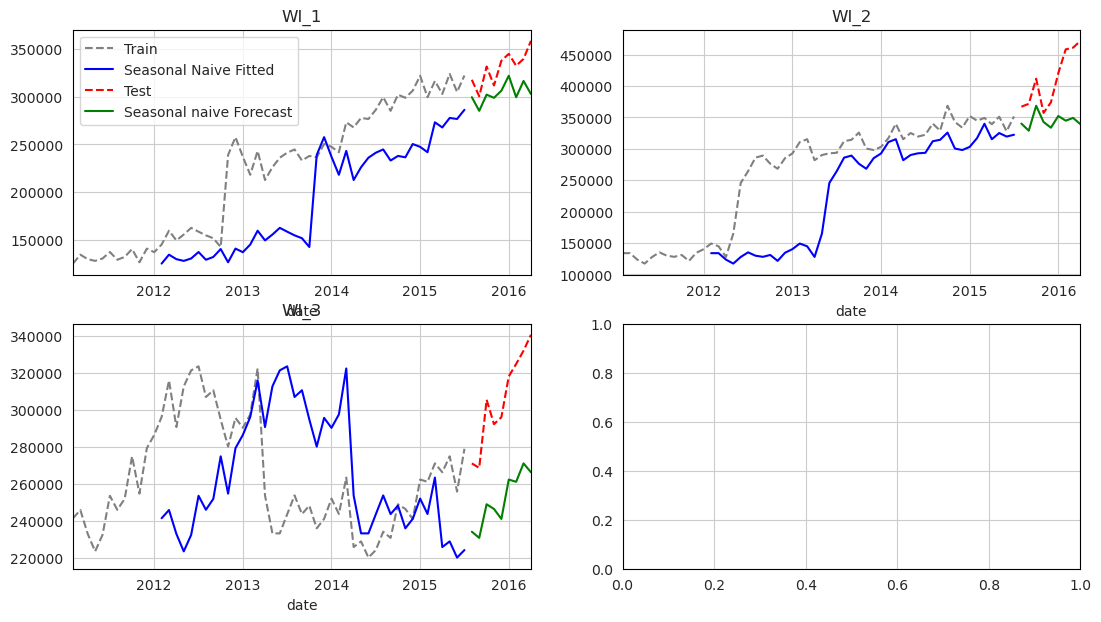

In [59]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_naive["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="Seasonal Naive Fitted",ax=axs).set_title(store_list[i])
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs).set_title(store_list[i])
    predicted_naive["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="Seasonal naive Forecast",ax=axs).set_title(store_list[i]);
fig.tight_layout()


In [60]:
for i in store_list:
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":"Seasonal Naive",
                  "MAPE":accuracy(Test[i],predicted_naive[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_naive[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [61]:
Model_Performance

store_id Forecast Method  MAPE     RMSE
0     WI_1  Seasonal Naive   8.0  29397.0
1     WI_2  Seasonal Naive  15.3  77432.7
2     WI_3  Seasonal Naive  17.5  55258.9

In [62]:
residual_naive=[(Train[i]-fit_naive[i]).dropna() for i in store_list]



 Store Name WI_1

** Mean of the residuals:  49666.11



** Ljung Box Test, p-value: 0.00018522283346025637 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.59 (>0.05, Normal)



** AD Fuller, p_value: 0.032683393467710785 (<0.05, Stationary)


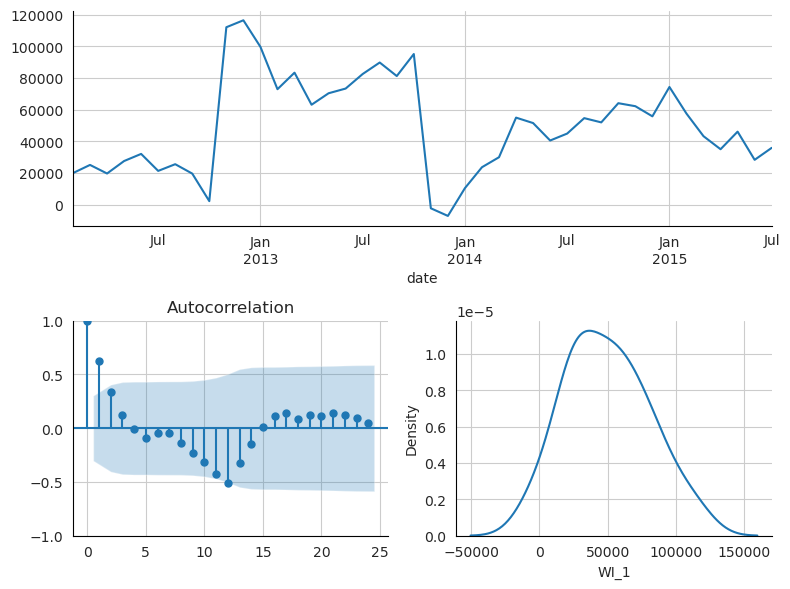



 Store Name WI_2

** Mean of the residuals:  61289.02



** Ljung Box Test, p-value: 3.928716996116254e-11 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.029 (<0.05, Not-normal)



** AD Fuller, p_value: 0.11224937021844883 (>0.05, Non-stationary)


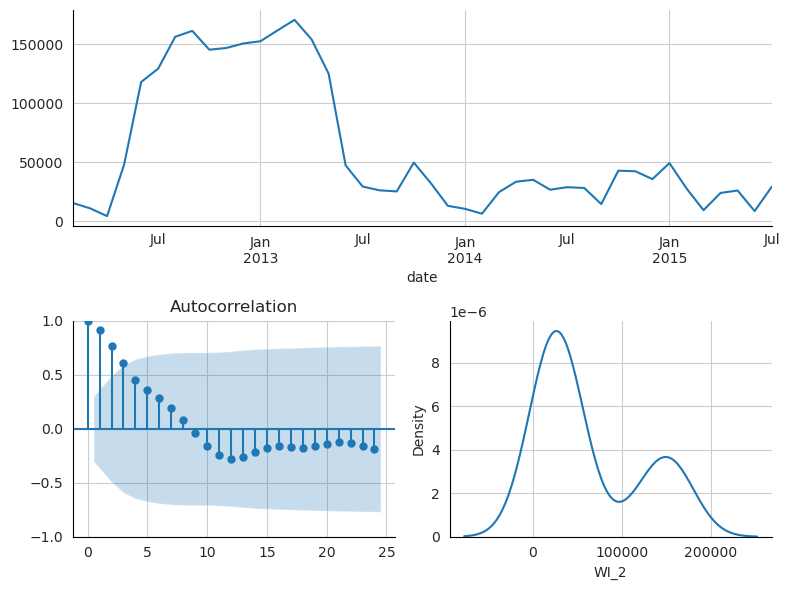



 Store Name WI_3

** Mean of the residuals:  1163.56



** Ljung Box Test, p-value: 6.410509827842523e-11 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.484 (>0.05, Normal)



** AD Fuller, p_value: 0.669314687508566 (>0.05, Non-stationary)


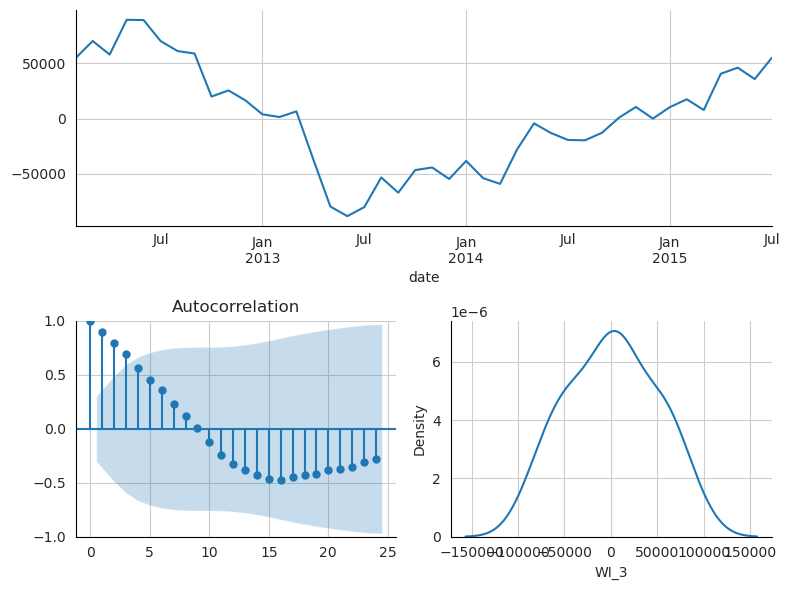

In [63]:
for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(residual_naive[i],24);
    plt.show()

### HoltsWinter Exponential Smoothing Model

In [64]:
def HoltsWinterGrid(train,test,seasonal_periods):
    trend=["add","mul"]
    seasonal=["add","mul"]
    damped=[False,True]
    use_boxcox=[True,False,"log"]
    
    params=itertools.product(trend,seasonal,damped,use_boxcox)
    result_df=pd.DataFrame(columns=["Trend","Seasonal","Damped","Box_Cox","AICc_Train","MAPE_Train",
                                   "RMSE_Train","MAPE_Test","RMSE_Test","lj_residual","jb_norm_residual",
                                   "resid_mean"])
    
    for trend,seasonal,damped,boxcox in params:
        if boxcox!="log":
            model=ExponentialSmoothing(train,
                                       trend=trend,
                                       seasonal=seasonal,
                                       damped_trend=damped,
                                       seasonal_periods=seasonal_periods,
                                       use_boxcox=boxcox,
                                       initialization_method="heuristic",
                                       freq='MS').fit()

            MAPE_Train=MAPE(train,model.fittedvalues)
            rmse_train=rmse(train,model.fittedvalues)

            MAPE_Test=MAPE(test,model.forecast(len(test)))
            rmse_test=rmse(test,model.forecast(len(test)))
            resid=model.resid
            
        else:
            trainlog=np.log(train)
            model=ExponentialSmoothing(trainlog,
                                   trend=trend,
                                   seasonal=seasonal,
                                   damped_trend=damped,
                                   seasonal_periods=seasonal_periods,
                                   use_boxcox=False,
                                   initialization_method="heuristic",
                                   freq='MS').fit()
        
            MAPE_Train=MAPE(train,np.exp(model.fittedvalues))
            rmse_train=rmse(train,np.exp(model.fittedvalues))
        
            MAPE_Test=MAPE(test,np.exp(model.forecast(len(test))))
            rmse_test=rmse(test,np.exp(model.forecast(len(test))))
            resid=train-np.exp(model.fittedvalues)
        
        
        ljp_p_val=np.mean(ljung(resid,lags=20,return_df=False)[1])
        norm_p=jb(resid)[1]
        lj_residual="Uncorrelated" if ljp_p_val>0.05 else "Corelated"
        norm_p="Normal" if norm_p>0.05 else "Not Normal"
       
        Aicc=model.aicc.round(1)
        
        result_df = pd.concat([result_df,
                              pd.DataFrame({
                                  'Trend':[trend],
                                  'Seasonal': [seasonal],
                                  'Damped':[damped],
                                  'Box_Cox':[boxcox],
                                  'MAPE_Train':[np.round(MAPE_Train,2)],
                                  'RMSE_Train':[np.round(rmse_train,1)],
                                  'AICc_Train':[Aicc],
                                  'MAPE_Test':[np.round(MAPE_Test,2)],
                                  'RMSE_Test':[np.round(rmse_test,1)],
                                  'lj_residual' :[lj_residual],
                                  'jb_norm_residual':[norm_p],
                                  'resid_mean':[np.round(resid.mean(),1)]})] ,
                              ignore_index=True, 
                              sort=False)
            
    return result_df.sort_values(by=["RMSE_Test","MAPE_Test","RMSE_Train","MAPE_Train"])

In [65]:
HW_model_all=pd.DataFrame()
HW_model_best=pd.DataFrame()
for i,j in enumerate(store_list):
    temp2=HoltsWinterGrid(Train[j], Test[j], seasonal_periods=12)
    temp2["store_id"]=j
    HW_model_all=pd.concat([HW_model_all,temp2],ignore_index=True)
    HW_model_best=pd.concat([HW_model_best,temp2.head(1)],ignore_index=True)

In [66]:
HW_model_all[HW_model_all["store_id"]=="WI_2"]

Trend Seasonal Damped Box_Cox  AICc_Train  MAPE_Train  RMSE_Train  \
24   mul      add  False     log      -239.3         4.1     16429.1   
25   add      add  False     log      -239.5         4.1     16408.5   
26   add      add  False    True      1117.1         7.6     19264.8   
27   add      add   True   False      1102.8         5.0     16150.4   
28   add      add  False   False      1099.8         5.1     16418.7   
29   add      add   True    True      1121.8         7.6     19253.3   
30   mul      add  False    True      1138.0         9.6     23390.6   
31   mul      add   True    True      1141.0         9.4     23001.7   
32   add      mul  False    True      1113.6         5.9     18659.7   
33   add      add   True     log      -235.3         4.2     16192.8   
34   add      mul   True   False      1119.3         5.1     18817.2   
35   mul      add   True   False      1100.8         4.9     15852.1   
36   mul      add  False   False      1099.3         5.1     16333.8   
37   add      mul  False   False      1116.2         5.1     19114.0   
38   add      mul   True    True      1117.8         5.8     18555.4   
39   mul      mul   True   False      1125.2         5.4     19869.1   
40   mul      mul  False    True      1129.2         7.3     21560.1   
41   mul      mul   True    True      1132.2         7.0     21196.1   
42   mul      mul  False   False      1122.1         5.5     20182.0   
43   mul      add   True     log      -188.6         9.6     28658.9   
44   add      mul  False     log         NaN         NaN         NaN   
45   add      mul   True     log         NaN         NaN         NaN   
46   mul      mul  False     log         NaN         NaN         NaN   
47   mul      mul   True     log         NaN         NaN         NaN   

    MAPE_Test  RMSE_Test   lj_residual jb_norm_residual  resid_mean store_id  
24        8.9    52529.0  Uncorrelated       Not Normal      -662.7     WI_2  
25        9.0    52763.5  Uncorrelated       Not Normal      -722.8     WI_2  
26        9.0    53689.0  Uncorrelated       Not Normal     -2299.8     WI_2  
27        9.7    57667.5  Uncorrelated       Not Normal     -2019.2     WI_2  
28       10.6    61823.7  Uncorrelated       Not Normal     -2337.3     WI_2  
29       11.3    64013.8  Uncorrelated       Not Normal      -791.3     WI_2  
30       12.1    67911.3  Uncorrelated           Normal     -5520.1     WI_2  
31       12.1    67992.1  Uncorrelated           Normal     -5442.1     WI_2  
32       11.9    68549.5  Uncorrelated       Not Normal     -2771.2     WI_2  
33       12.4    68560.7  Uncorrelated       Not Normal      -446.8     WI_2  
34       12.2    69494.6  Uncorrelated       Not Normal     -2253.3     WI_2  
35       13.4    73255.7  Uncorrelated       Not Normal     -2048.2     WI_2  
36       13.9    74849.6  Uncorrelated       Not Normal     -2906.6     WI_2  
37       13.4    75275.3  Uncorrelated       Not Normal     -2581.2     WI_2  
38       14.0    78357.7  Uncorrelated       Not Normal     -1464.3     WI_2  
39       14.8    81556.9  Uncorrelated       Not Normal     -4085.0     WI_2  
40       15.2    83788.9  Uncorrelated           Normal     -6583.0     WI_2  
41       15.5    85403.4  Uncorrelated           Normal     -5720.7     WI_2  
42       15.8    86354.8  Uncorrelated       Not Normal     -4109.3     WI_2  
43       74.1   380855.3  Uncorrelated       Not Normal    -21620.6     WI_2  
44        NaN        NaN     Corelated       Not Normal         NaN     WI_2  
45        NaN        NaN     Corelated       Not Normal         NaN     WI_2  
46        NaN        NaN     Corelated       Not Normal         NaN     WI_2  
47        NaN        NaN     Corelated       Not Normal         NaN     WI_2

In [67]:
HW_model_best=HW_model_best.set_index("store_id")
HW_model_best

Trend Seasonal Damped Box_Cox  AICc_Train  MAPE_Train  RMSE_Train  \
store_id                                                                     
WI_1       add      add   True    True      1094.5         4.6     14949.3   
WI_2       mul      add  False     log      -239.3         4.1     16429.1   
WI_3       mul      add  False     log      -286.5         3.5     11913.5   

          MAPE_Test  RMSE_Test   lj_residual jb_norm_residual  resid_mean  
store_id                                                                   
WI_1            3.7    15017.1  Uncorrelated       Not Normal       813.5  
WI_2            8.9    52529.0  Uncorrelated       Not Normal      -662.7  
WI_3            3.6    14140.9  Uncorrelated           Normal      -358.4

In [68]:
predicted_HW=pd.DataFrame(columns=store_list)
fit_HW=pd.DataFrame(columns=store_list)
for i in store_list:
    if HW_model_best.loc[i].Box_Cox!="log":
            model=ExponentialSmoothing(Train[i],
                                       trend=HW_model_best.loc[i].Trend,
                                       seasonal=HW_model_best.loc[i].Seasonal,
                                       damped_trend=HW_model_best.loc[i].Damped,
                                       seasonal_periods=12,
                                       use_boxcox=HW_model_best.loc[i].Box_Cox,
                                       initialization_method="heuristic",
                                       freq='MS').fit()

            fit_HW[i]=model.fittedvalues
            predicted_HW[i]=model.forecast(len(Test))
            
    else:
            model=ExponentialSmoothing(np.log(Train[i]),
                                   trend=HW_model_best.loc[i].Trend,
                                   seasonal=HW_model_best.loc[i].Seasonal,
                                   damped_trend=HW_model_best.loc[i].Damped,
                                   seasonal_periods=12,
                                   use_boxcox=False,
                                   initialization_method="heuristic",
                                   freq='MS').fit()
            fit_HW[i]=np.exp(model.fittedvalues)
            predicted_HW[i]=np.exp(model.forecast(len(Test)))

KeyError: 'WI_4'

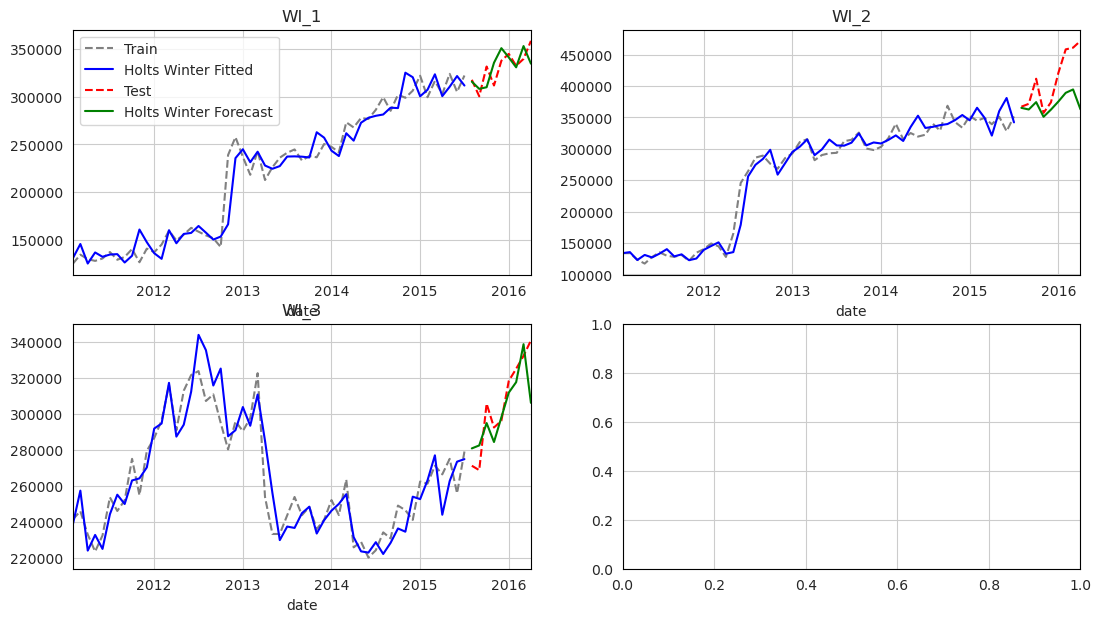

In [69]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_HW["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="Holts Winter Fitted",ax=axs)
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_HW["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="Holts Winter Forecast",ax=axs)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels,bbox_to_anchor=(0.975,0.85,0.1,0.04))
fig.tight_layout()



 Store Name WI_1

** Mean of the residuals:  813.49



** Ljung Box Test, p-value: 0.5483771161578852 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 7.321203818958657e-10 (<0.05, Stationary)


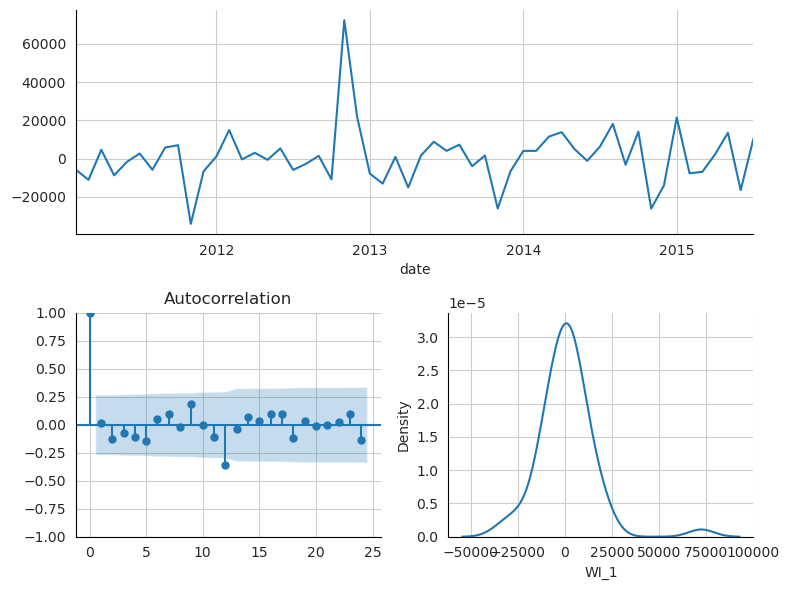



 Store Name WI_2

** Mean of the residuals:  -662.68



** Ljung Box Test, p-value: 0.3171431951105504 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 0.3934447104494246 (>0.05, Non-stationary)


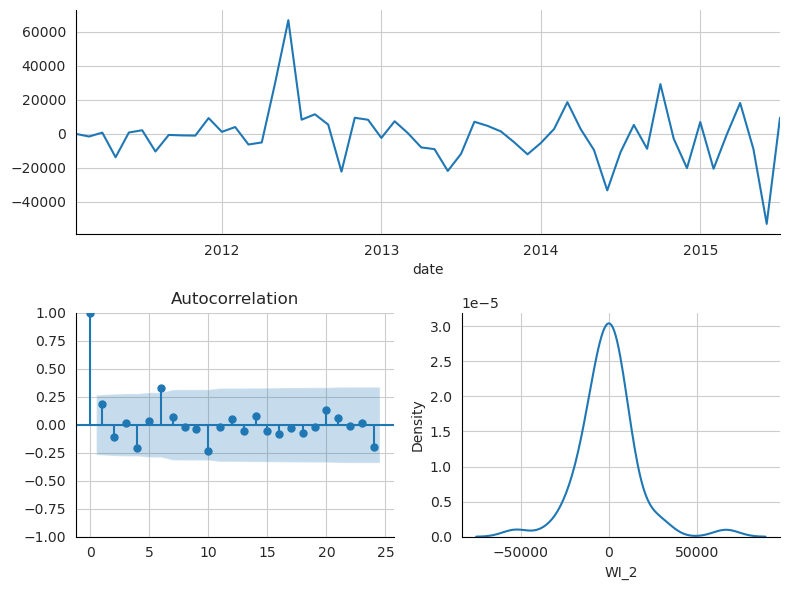



 Store Name WI_3

** Mean of the residuals:  -358.4



** Ljung Box Test, p-value: 0.4759322954714838 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.08 (>0.05, Normal)



** AD Fuller, p_value: 2.625969434747747e-09 (<0.05, Stationary)


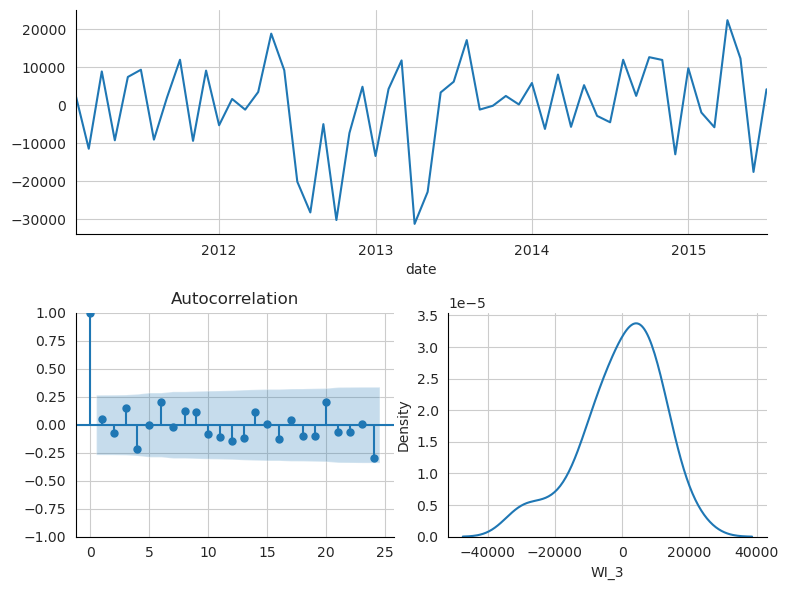

In [70]:
residual_HW=[(Train[i]-fit_HW[i]).dropna() for i in store_list]
for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(residual_HW[i],24);
    plt.show()

In [71]:
for i in store_list:
    if HW_model_best.loc[i].Box_Cox=="log":
        model_name="Holts-Winter Log"
    elif HW_model_best.loc[i].Box_Cox==True:
        model_name="Holts-Winter Box-Cox"
    else:
        model_name="Holts-Winter"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_HW[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_HW[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [72]:
Model_Performance

store_id       Forecast Method  MAPE     RMSE
0     WI_1        Seasonal Naive   8.0  29397.0
1     WI_2        Seasonal Naive  15.3  77432.7
2     WI_3        Seasonal Naive  17.5  55258.9
3     WI_1  Holts-Winter Box-Cox   3.7  15017.1
4     WI_2      Holts-Winter Log   8.9  52529.0
5     WI_3      Holts-Winter Log   3.6  14140.9

### ETS Model Statespace Aproach Log

In [73]:
predicted_ETSL=pd.DataFrame(columns=store_list)
fit_ETSL=pd.DataFrame(columns=store_list)
resid_ETSL=pd.DataFrame(columns=store_list)
ETSL_models=[]
for i in store_list:
    ets_LAdA=sm.tsa.statespace.ExponentialSmoothing(np.log(Train[i]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)

    predicted_ETSL[i] = np.exp(ets_LAdA.forecast(len(Test[i])))
    fit_ETSL[i]=np.exp(ets_LAdA.fittedvalues)
    resid_ETSL[i]=Train[i]-fit_ETSL[i]
    ETSL_models.append(ets_LAdA)

KeyError: 'WI_4'

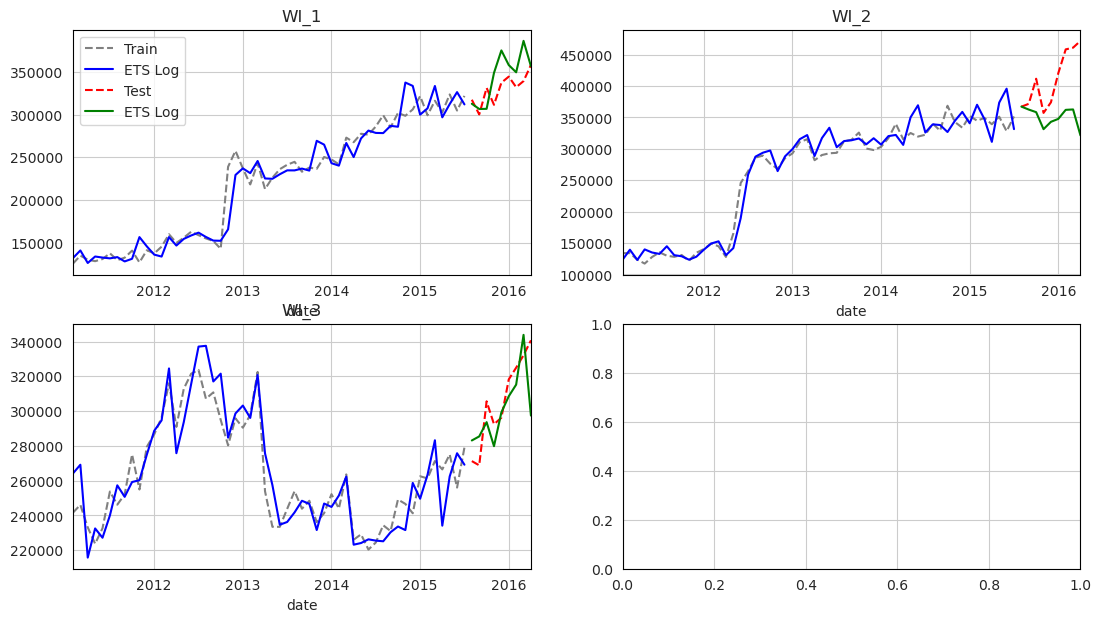

In [74]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_ETSL["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="ETS Log",ax=axs)
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_ETSL["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="ETS Log",ax=axs)
fig.tight_layout()

In [75]:
for i in store_list:
    model_name="ETS Log"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_ETSL[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_ETSL[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [76]:
Model_Performance

store_id       Forecast Method  MAPE     RMSE
0     WI_1        Seasonal Naive   8.0  29397.0
1     WI_2        Seasonal Naive  15.3  77432.7
2     WI_3        Seasonal Naive  17.5  55258.9
3     WI_1  Holts-Winter Box-Cox   3.7  15017.1
4     WI_2      Holts-Winter Log   8.9  52529.0
5     WI_3      Holts-Winter Log   3.6  14140.9
6     WI_1               ETS Log   6.4  26259.2
7     WI_2               ETS Log  13.6  75655.2
8     WI_3               ETS Log   4.7  18039.6



 Store Name WI_1

** Mean of the residuals:  782.32



** Ljung Box Test, p-value: 0.6815188682970978 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 1.2441184520646568e-08 (<0.05, Stationary)


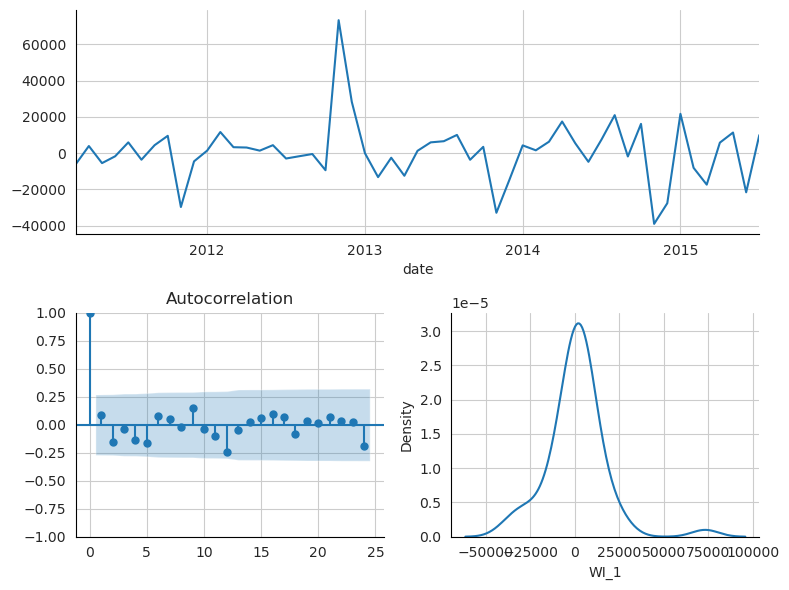



 Store Name WI_2

** Mean of the residuals:  -4101.12



** Ljung Box Test, p-value: 0.26121573939021997 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.001 (<0.05, Not-normal)



** AD Fuller, p_value: 0.23257095944457212 (>0.05, Non-stationary)


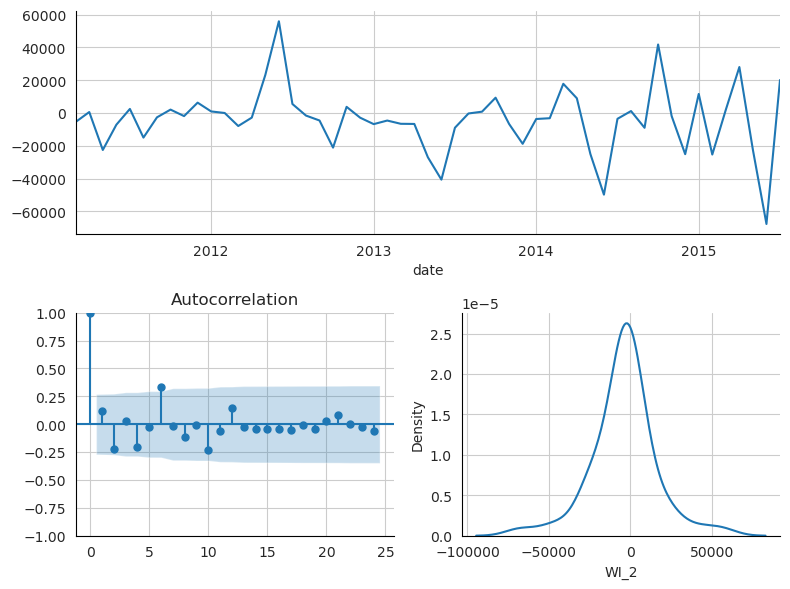



 Store Name WI_3

** Mean of the residuals:  -449.4



** Ljung Box Test, p-value: 0.6950620475703931 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.835 (>0.05, Normal)



** AD Fuller, p_value: 2.1223612656823274e-10 (<0.05, Stationary)


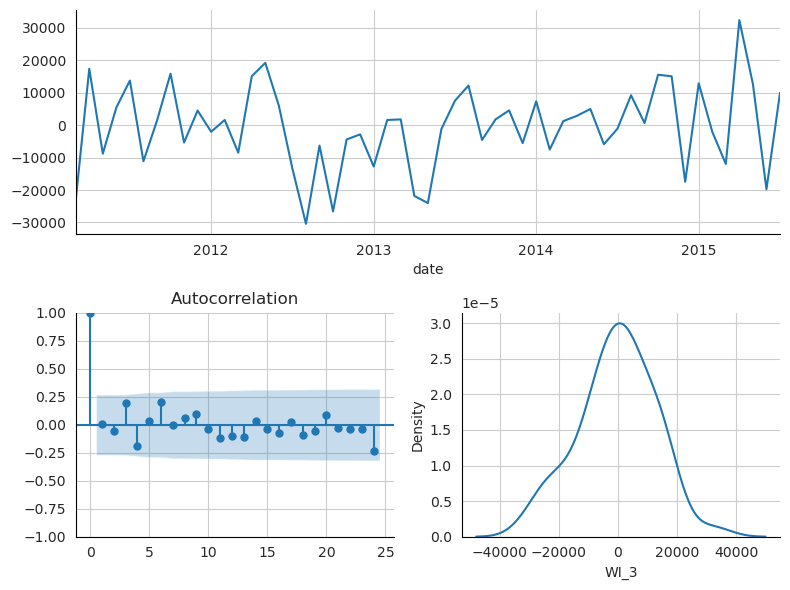

In [77]:
residual_ETSL=[(Train[i][1:]-fit_ETSL[i][1:]).dropna() for i in store_list]
for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(residual_ETSL[i],24);
    plt.show()

### ETS Model

In [78]:
predicted_ETS=pd.DataFrame(columns=store_list)
fit_ETS=pd.DataFrame(columns=store_list)
resid_ETS=pd.DataFrame(columns=store_list)
ETS_models=[]
for i in store_list:
    ets_AdA=sm.tsa.statespace.ExponentialSmoothing(Train[i],
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)

    predicted_ETS[i] = ets_AdA.forecast(len(Test[i]))
    fit_ETS[i]=ets_AdA.fittedvalues
    resid_ETS[i]=Train[i]-fit_ETS[i]
    ETS_models.append(ets_AdA)

KeyError: 'WI_4'

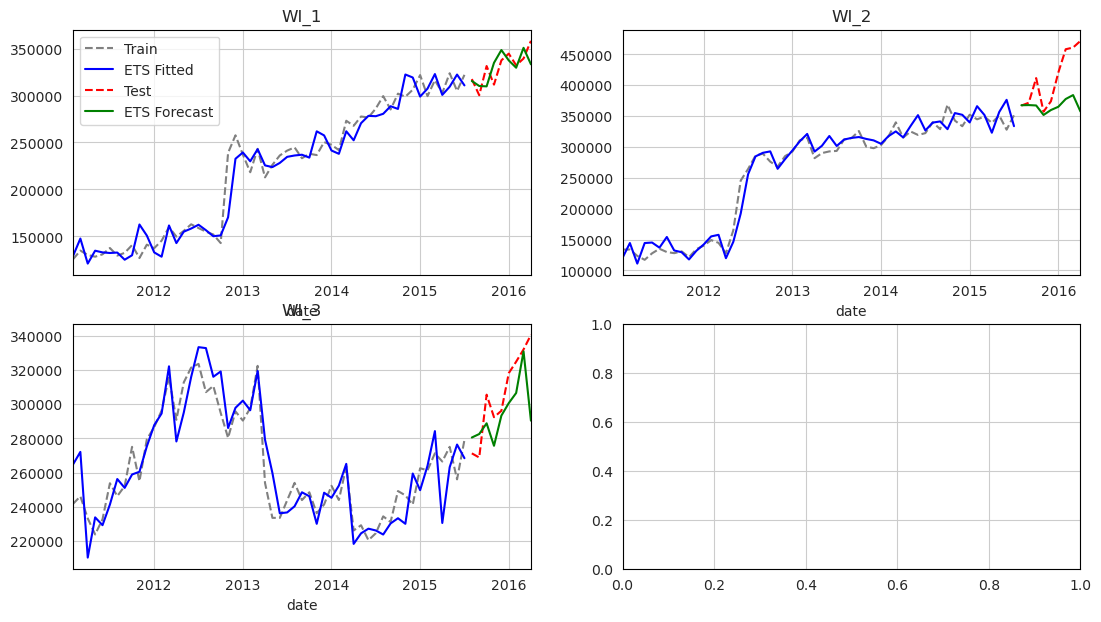

In [79]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_ETS["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="ETS Fitted",ax=axs)
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_ETS["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="ETS Forecast",ax=axs)
fig.tight_layout()

In [80]:
for i in store_list:
    model_name="ETS"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_ETS[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_ETS[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [81]:
Model_Performance

store_id       Forecast Method  MAPE     RMSE
0      WI_1        Seasonal Naive   8.0  29397.0
1      WI_2        Seasonal Naive  15.3  77432.7
2      WI_3        Seasonal Naive  17.5  55258.9
3      WI_1  Holts-Winter Box-Cox   3.7  15017.1
4      WI_2      Holts-Winter Log   8.9  52529.0
5      WI_3      Holts-Winter Log   3.6  14140.9
6      WI_1               ETS Log   6.4  26259.2
7      WI_2               ETS Log  13.6  75655.2
8      WI_3               ETS Log   4.7  18039.6
9      WI_1                   ETS   3.8  15062.7
10     WI_2                   ETS   9.9  58527.7
11     WI_3                   ETS   5.2  21138.7



 Store Name WI_1

** Mean of the residuals:  1939.6



** Ljung Box Test, p-value: 0.5043489374710607 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 9.096507592147672e-10 (<0.05, Stationary)


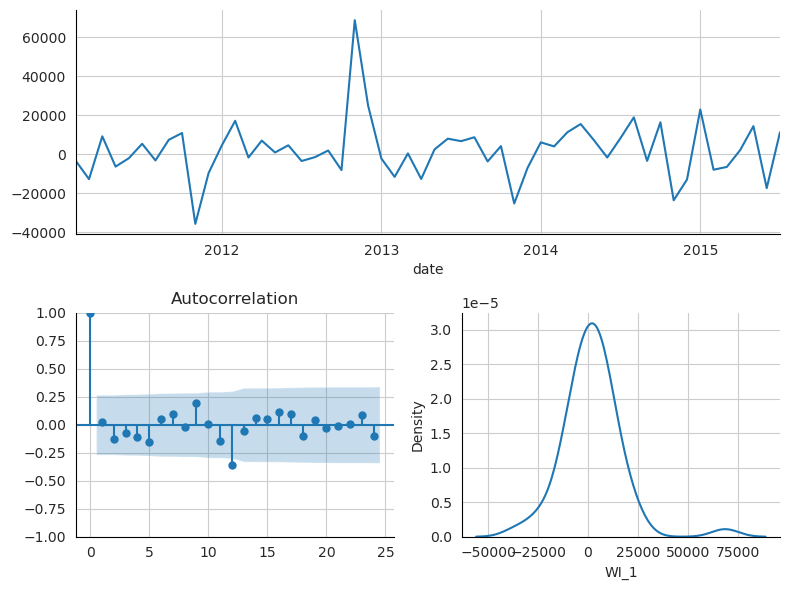



 Store Name WI_2

** Mean of the residuals:  -2553.64



** Ljung Box Test, p-value: 0.45121541835290957 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 0.05511203576118096 (>0.05, Non-stationary)


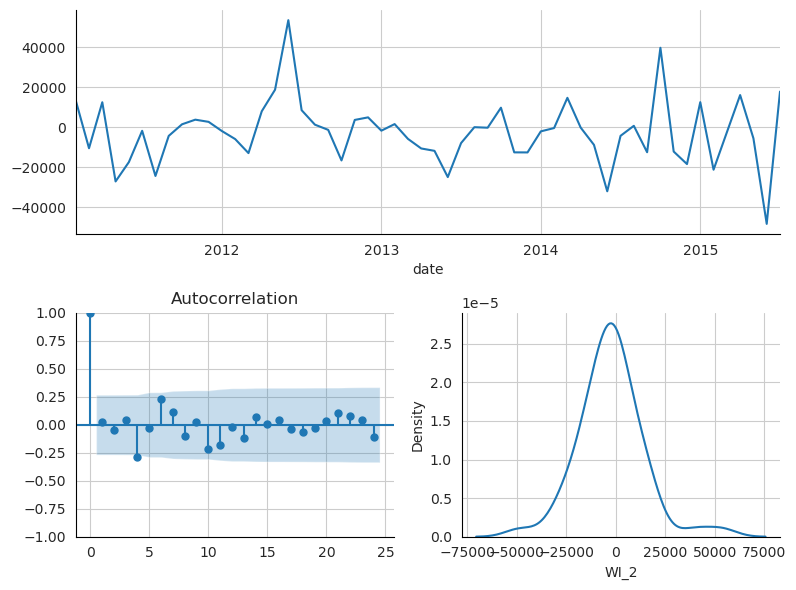



 Store Name WI_3

** Mean of the residuals:  -714.43



** Ljung Box Test, p-value: 0.4660694281987521 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.987 (>0.05, Normal)



** AD Fuller, p_value: 0.0014164205074743983 (<0.05, Stationary)


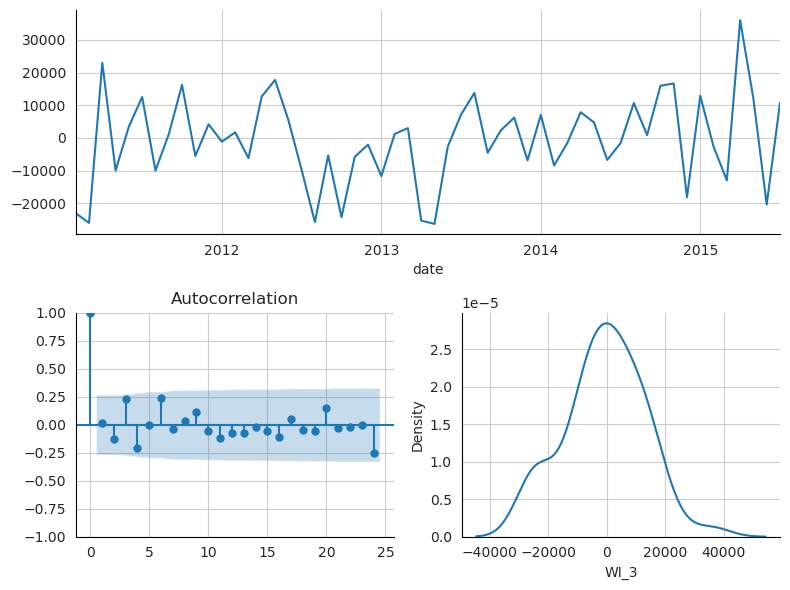

In [82]:

for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(resid_ETS["WI_"+str(i+1)],24);
    plt.show()

### SARIMA Models

In [83]:
best_arima=[]
for i in store_list:    
    best_arima.append(auto_arima(Train[i],
                                 seasonal=True,
                                 m=12,                         
                                 d=1,                   
                                 information_criterion='aicc'))

In [84]:
predicted_SARIMA=pd.DataFrame(columns=store_list)
fit_SARIMA=pd.DataFrame(columns=store_list)
resid_SARIMA=pd.DataFrame(columns=store_list)
for j,i in enumerate(store_list):
    sarima_model=SARIMAX(endog=Train[i],
                          **best_arima[j].get_params()
                         )
    sarima_fit=sarima_model.fit(disp=0)
    start = len(Train)
    end = len(Train) +len(Test) -1
    fit_SARIMA[i] = sarima_fit.fittedvalues
    resid_SARIMA[i] = sarima_fit.resid[1:]
    predicted_SARIMA[i] = sarima_fit.predict(start, end, dynamic=False)
    

KeyError: 'WI_4'

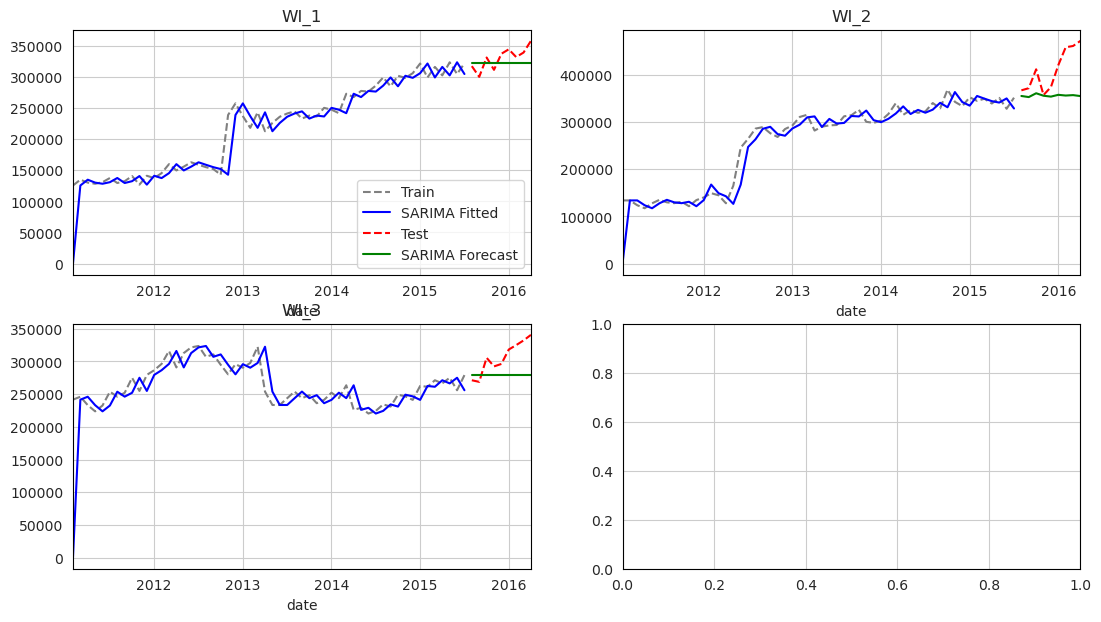

In [85]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_SARIMA["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="SARIMA Fitted",ax=axs)
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_SARIMA["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="SARIMA Forecast",ax=axs)
fig.tight_layout()

In [86]:
for i in store_list:
    model_name="SARIMA"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_SARIMA[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_SARIMA[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [87]:
Model_Performance

store_id       Forecast Method  MAPE     RMSE
0      WI_1        Seasonal Naive   8.0  29397.0
1      WI_2        Seasonal Naive  15.3  77432.7
2      WI_3        Seasonal Naive  17.5  55258.9
3      WI_1  Holts-Winter Box-Cox   3.7  15017.1
4      WI_2      Holts-Winter Log   8.9  52529.0
5      WI_3      Holts-Winter Log   3.6  14140.9
6      WI_1               ETS Log   6.4  26259.2
7      WI_2               ETS Log  13.6  75655.2
8      WI_3               ETS Log   4.7  18039.6
9      WI_1                   ETS   3.8  15062.7
10     WI_2                   ETS   9.9  58527.7
11     WI_3                   ETS   5.2  21138.7
12     WI_1                SARIMA   4.9  18711.2
13     WI_2                SARIMA  12.4  68681.9
14     WI_3                SARIMA   9.6  35862.7

In [88]:
best_arima[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -594.859
Date:                Sat, 04 Nov 2023   AIC                           1193.717
Time:                        15:40:05   BIC                           1197.658
Sample:                    02-01-2011   HQIC                          1195.232
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3706.1860   3250.822      1.140      0.254   -2665.309    1.01e+04
sigma2      3.284e+08   3.34e+07      9.845      0.000    2.63e+08    3.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.65   Jarque-Bera (JB):               288.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                             2.27
Prob(H) (two-sided):                  0.02   Kurtosis:                        13.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



 Store Name WI_1

** Mean of the residuals:  3706.19



** Ljung Box Test, p-value: 0.7043504579886783 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 2.51071825219286e-15 (<0.05, Stationary)


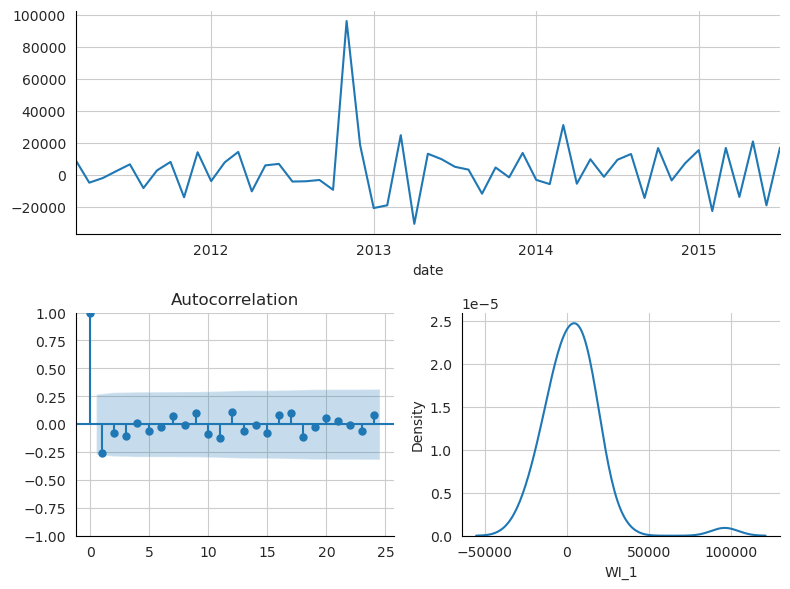



 Store Name WI_2

** Mean of the residuals:  2868.86



** Ljung Box Test, p-value: 0.2541565271465172 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 0.3148245937405203 (>0.05, Non-stationary)


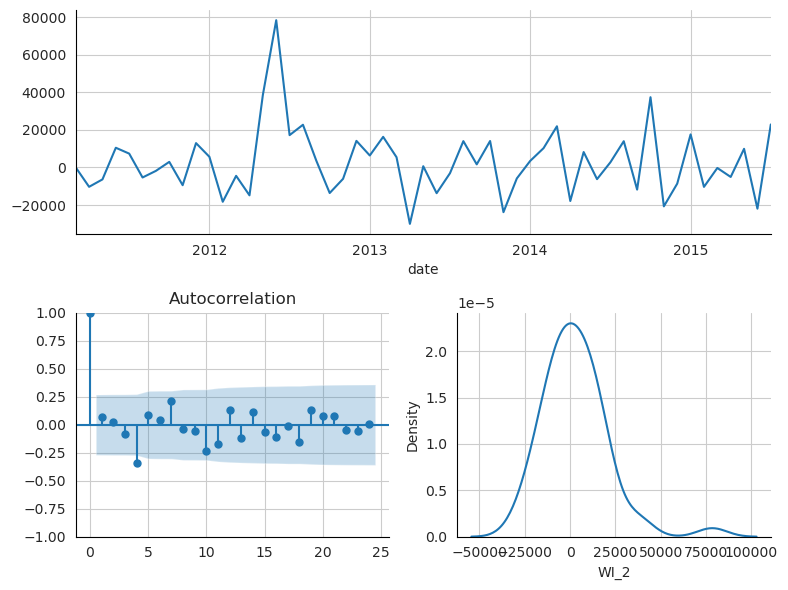



 Store Name WI_3

** Mean of the residuals:  707.95



** Ljung Box Test, p-value: 0.10683130553481048 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 5.1438482386726805e-15 (<0.05, Stationary)


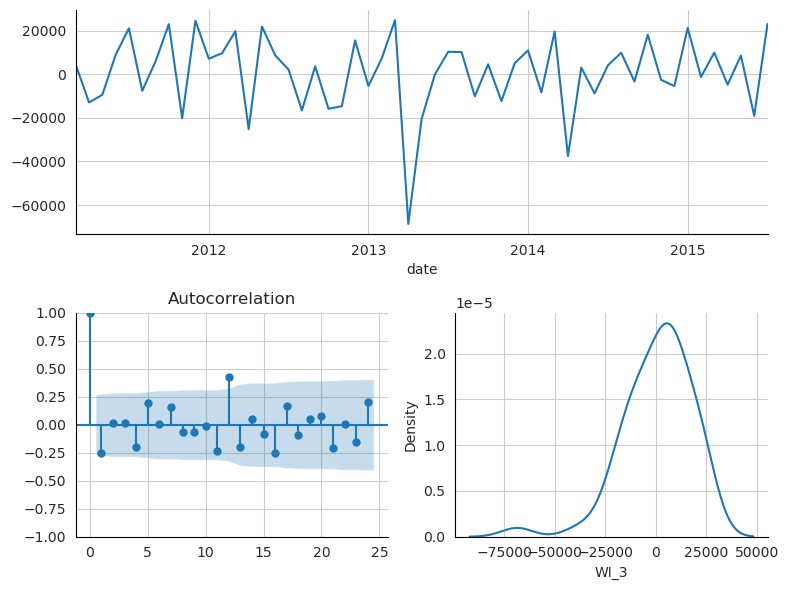

In [89]:
for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(resid_SARIMA["WI_"+str(i+1)],24);
    plt.show()

### SARIMA Log Models

In [90]:
best_arimaL=[]
Trainlog=np.log(Train)
for i in store_list:    
    best_arimaL.append(auto_arima(Trainlog[i],
                                 seasonal=True,
                                 m=12,                         
                                 d=1,                   
                                 information_criterion='aicc'))

In [91]:
predicted_SARIMAL=pd.DataFrame(columns=store_list)
fit_SARIMAL=pd.DataFrame(columns=store_list)
resid_SARIMAL=pd.DataFrame(columns=store_list)
for j,i in enumerate(store_list):
    sarima_model=SARIMAX(endog=Trainlog[i],
                          **best_arimaL[j].get_params()
                         )
    sarima_fit=sarima_model.fit(disp=0)
    start = len(Train)
    end = len(Train) +len(Test) -1
    fit_SARIMAL[i] = np.exp(sarima_fit.fittedvalues)
    resid_SARIMAL[i] = Train[i][1:]-fit_SARIMAL[i][1:]
    predicted_SARIMAL[i] = np.exp(sarima_fit.predict(start, end, dynamic=False))

KeyError: 'WI_4'

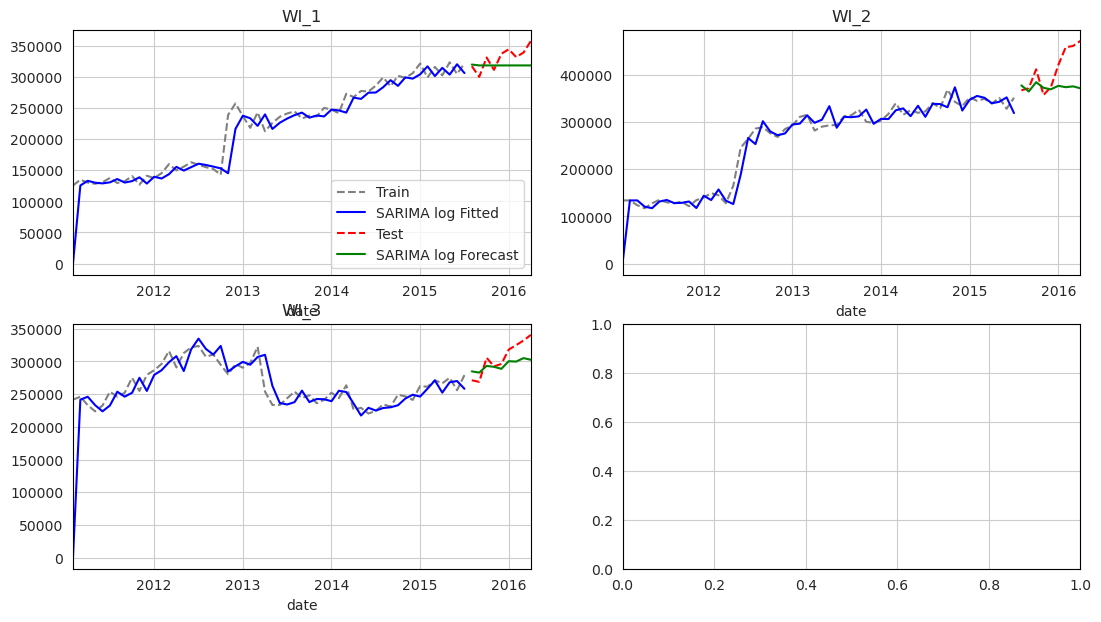

In [92]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_SARIMAL["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="SARIMA log Fitted",ax=axs)
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_SARIMAL["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="SARIMA log Forecast",ax=axs)
fig.tight_layout()

In [93]:
for i in store_list:
    model_name="SARIMA Log"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_SARIMAL[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_SARIMAL[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [94]:
Model_Performance

store_id       Forecast Method  MAPE     RMSE
0      WI_1        Seasonal Naive   8.0  29397.0
1      WI_2        Seasonal Naive  15.3  77432.7
2      WI_3        Seasonal Naive  17.5  55258.9
3      WI_1  Holts-Winter Box-Cox   3.7  15017.1
4      WI_2      Holts-Winter Log   8.9  52529.0
5      WI_3      Holts-Winter Log   3.6  14140.9
6      WI_1               ETS Log   6.4  26259.2
7      WI_2               ETS Log  13.6  75655.2
8      WI_3               ETS Log   4.7  18039.6
9      WI_1                   ETS   3.8  15062.7
10     WI_2                   ETS   9.9  58527.7
11     WI_3                   ETS   5.2  21138.7
12     WI_1                SARIMA   4.9  18711.2
13     WI_2                SARIMA  12.4  68681.9
14     WI_3                SARIMA   9.6  35862.7
15     WI_1            SARIMA Log   5.3  20416.9
16     WI_2            SARIMA Log   9.5  55459.0
17     WI_3            SARIMA Log   5.5  20355.0



 Store Name WI_1

** Mean of the residuals:  5420.17



** Ljung Box Test, p-value: 0.9090847923496344 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 9.416966163277887e-12 (<0.05, Stationary)


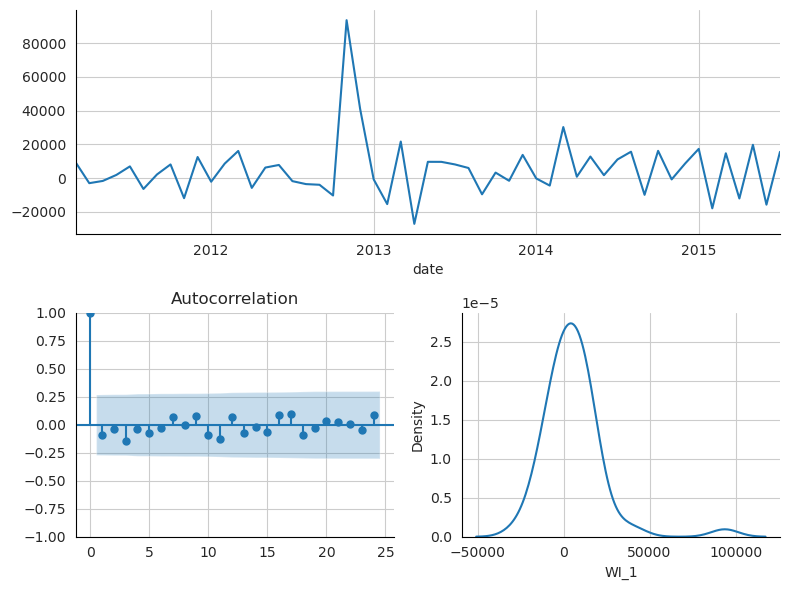



 Store Name WI_2

** Mean of the residuals:  1736.75



** Ljung Box Test, p-value: 0.35356053598728465 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.019 (<0.05, Not-normal)



** AD Fuller, p_value: 3.2833015157191773e-12 (<0.05, Stationary)


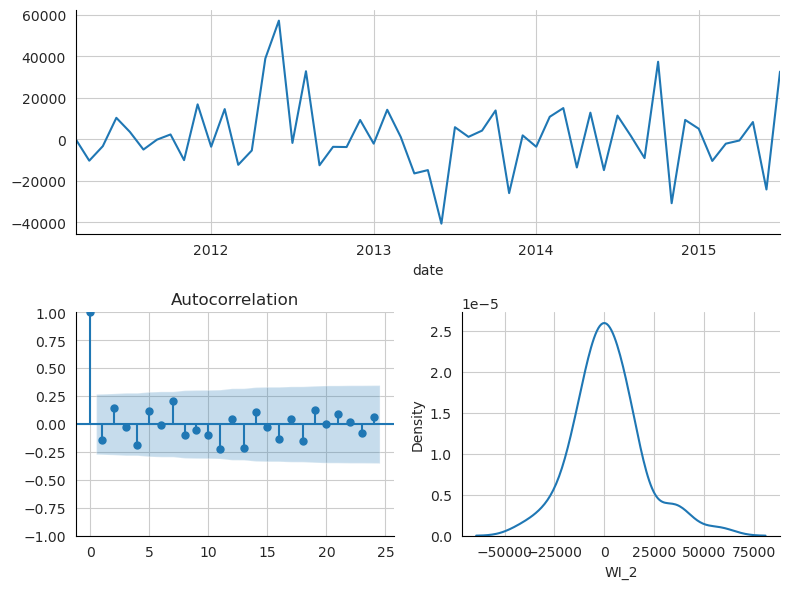



 Store Name WI_3

** Mean of the residuals:  770.52



** Ljung Box Test, p-value: 0.7526233337258098 (>0.05, Uncorrelated)



** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)



** AD Fuller, p_value: 1.1155416946179149e-11 (<0.05, Stationary)


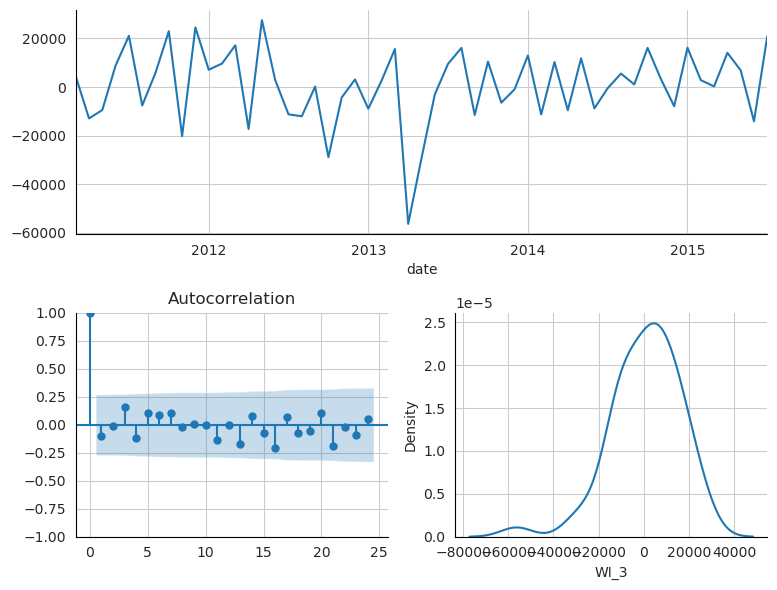

In [95]:
for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(resid_SARIMAL["WI_"+str(i+1)],24);
    plt.show()

For CA1, Residuals are uncorelated, not normal and stationary.

For CA2, residuals are uncorelated, not normal and non stationary.

For CA3 and CA4, residuals are uncorelated, normal, stationary.

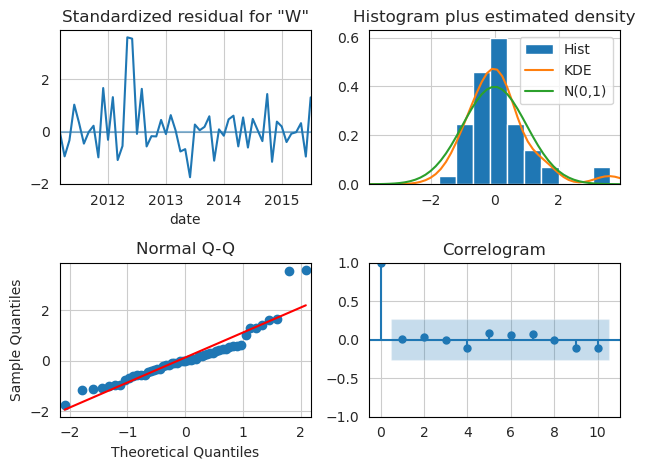

In [96]:
SARIMAX(endog=Trainlog["WI_2"],**best_arimaL[1].get_params()).fit(disp=0).plot_diagnostics()
plt.tight_layout()
plt.show()

### FB Prophet Model

In [97]:
import os
import sys

class suppress_stdout_stderr(object):
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])


In [98]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

predicted_prophet_add=pd.DataFrame(columns=store_list)
fit_prophet_add=pd.DataFrame(columns=store_list)
resid_prophet_add=pd.DataFrame(columns=store_list)

predicted_prophet_mul=pd.DataFrame(columns=store_list)
fit_prophet_mul=pd.DataFrame(columns=store_list)
resid_prophet_mul=pd.DataFrame(columns=store_list)

prophetmodels=[]

for i in store_list:
    train_fb_prophet=Train[i].reset_index()
    train_fb_prophet.columns=["ds","y"]  
    test_fb_prophet=Test[i].reset_index()
    test_fb_prophet.columns=["ds","y"]
    seasonality_mode=["multiplicative","additive"]
    for j in seasonality_mode:
        with suppress_stdout_stderr(): 
            prophet_model=Prophet(weekly_seasonality=False,
                                  daily_seasonality=False,
                                  yearly_seasonality=True,
                                  seasonality_mode=j).fit(train_fb_prophet)
        fb_dataframe=prophet_model.make_future_dataframe(len(Test),freq='MS',include_history=True)
        predicted_prophet=prophet_model.predict(fb_dataframe).set_index("ds")
        if j=="multiplicative":
            predicted_prophet_mul[i]=predicted_prophet[Test.index[0]:]["yhat"]
            fit_prophet_mul[i]=predicted_prophet[:Train.index[-1]]["yhat"]
            resid_prophet_mul[i]=Train[i]-fit_prophet_mul[i]
        else:
            predicted_prophet_add[i]=predicted_prophet[Test.index[0]:]["yhat"]
            fit_prophet_add[i]=predicted_prophet[:Train.index[-1]]["yhat"]
            resid_prophet_add[i]=Train[i]-fit_prophet_add[i]
            prophetmodels.append(prophet_model)


15:40:48 - cmdstanpy - INFO - Chain [1] start processing

15:40:49 - cmdstanpy - INFO - Chain [1] done processing

15:40:49 - cmdstanpy - INFO - Chain [1] start processing

15:40:49 - cmdstanpy - INFO - Chain [1] done processing

15:40:50 - cmdstanpy - INFO - Chain [1] start processing

15:40:50 - cmdstanpy - INFO - Chain [1] done processing

15:40:51 - cmdstanpy - INFO - Chain [1] start processing

15:40:51 - cmdstanpy - INFO - Chain [1] done processing

15:40:52 - cmdstanpy - INFO - Chain [1] start processing

15:40:52 - cmdstanpy - INFO - Chain [1] done processing

15:40:53 - cmdstanpy - INFO - Chain [1] start processing

15:40:53 - cmdstanpy - INFO - Chain [1] done processing


KeyError: 'WI_4'

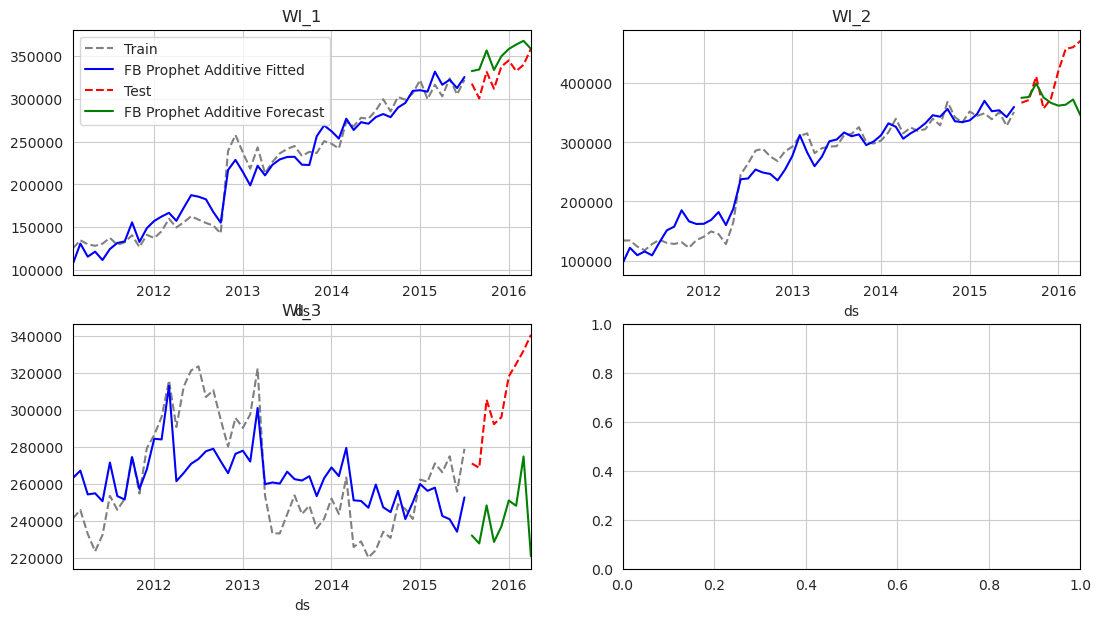

In [99]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_prophet_add["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="FB Prophet Additive Fitted",ax=axs)
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_prophet_add["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="FB Prophet Additive Forecast",ax=axs)
fig.tight_layout()

In [100]:
for i in store_list:
    model_name="Prophet Additive"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_prophet_add[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_prophet_add[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

KeyError: 'WI_4'

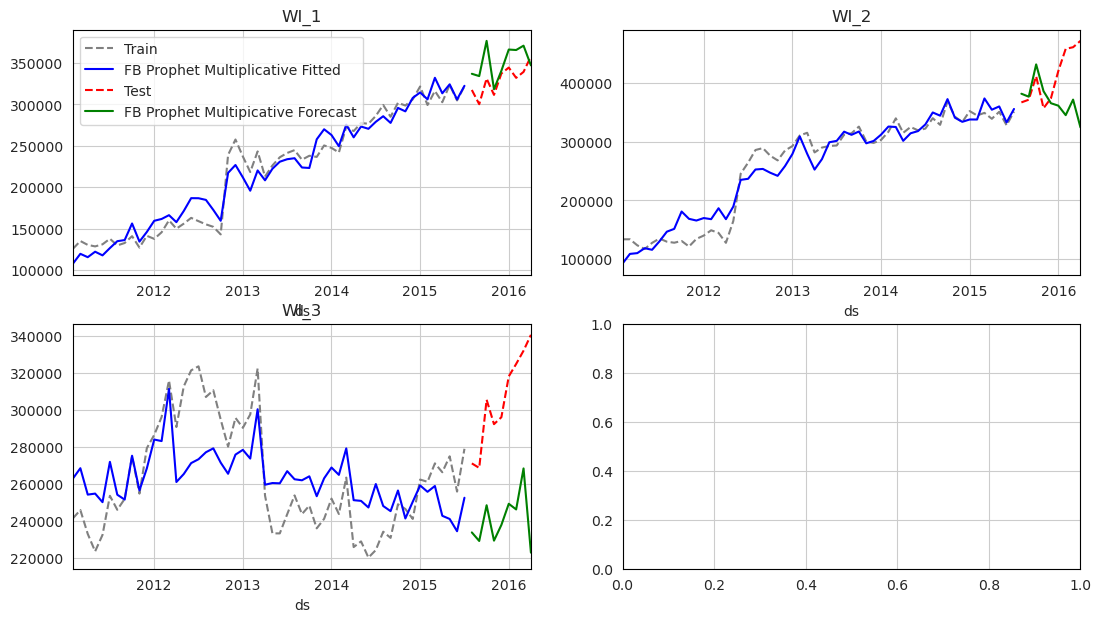

In [101]:
fig,ax=plt.subplots(figsize=(13,7),nrows=2,ncols=2)
for i, axs in enumerate(ax.flat):
    Train["WI_"+str(i+1)].plot(style="--", color="gray",legend=(i==0), label="Train",ax=axs).set_title(store_list[i])
    fit_prophet_mul["WI_"+str(i+1)].dropna().plot(color="b",legend=(i==0) ,label="FB Prophet Multiplicative Fitted",ax=axs)
    Test["WI_"+str(i+1)].plot(style="--",color="r", legend=(i==0),label="Test",ax=axs)
    predicted_prophet_mul["WI_"+str(i+1)].plot(color="g",legend=(i==0) ,label="FB Prophet Multipicative Forecast",ax=axs)
fig.tight_layout()

In [104]:
for i in store_list:
    model_name="Prophet Multiplicative"
    temp=pd.DataFrame({"store_id":i,
                  "Forecast Method":model_name,
                  "MAPE":accuracy(Test[i],predicted_prophet_mul[i]).MAPE,
                  "RMSE":accuracy(Test[i],predicted_prophet_mul[i]).RMSE})
    Model_Performance=pd.concat([Model_Performance,temp],axis=0,ignore_index=True)

In [105]:
Model_Performance

store_id         Forecast Method  MAPE     RMSE
0      WI_1          Seasonal Naive   8.0  29397.0
1      WI_2          Seasonal Naive  15.3  77432.7
2      WI_3          Seasonal Naive  17.5  55258.9
3      WI_1    Holts-Winter Box-Cox   3.7  15017.1
4      WI_2        Holts-Winter Log   8.9  52529.0
5      WI_3        Holts-Winter Log   3.6  14140.9
6      WI_1                 ETS Log   6.4  26259.2
7      WI_2                 ETS Log  13.6  75655.2
8      WI_3                 ETS Log   4.7  18039.6
9      WI_1                     ETS   3.8  15062.7
10     WI_2                     ETS   9.9  58527.7
11     WI_3                     ETS   5.2  21138.7
12     WI_1                  SARIMA   4.9  18711.2
13     WI_2                  SARIMA  12.4  68681.9
14     WI_3                  SARIMA   9.6  35862.7
15     WI_1              SARIMA Log   5.3  20416.9
16     WI_2              SARIMA Log   9.5  55459.0
17     WI_3              SARIMA Log   5.5  20355.0
18     WI_1        Prophet Additive   6.1  22368.9
19     WI_2        Prophet Additive  10.5  63911.5
20     WI_3        Prophet Additive  20.8  68254.0
21     WI_1  Prophet Multiplicative   7.0  26666.7
22     WI_2  Prophet Multiplicative  12.2  72688.0
23     WI_3  Prophet Multiplicative  20.9  68605.1



 Store Name WI_1

** Mean of the residuals:  0.67



** Ljung Box Test, p-value: 6.419905474109861e-09 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.374 (>0.05, Normal)



** AD Fuller, p_value: 0.028461766833702273 (<0.05, Stationary)


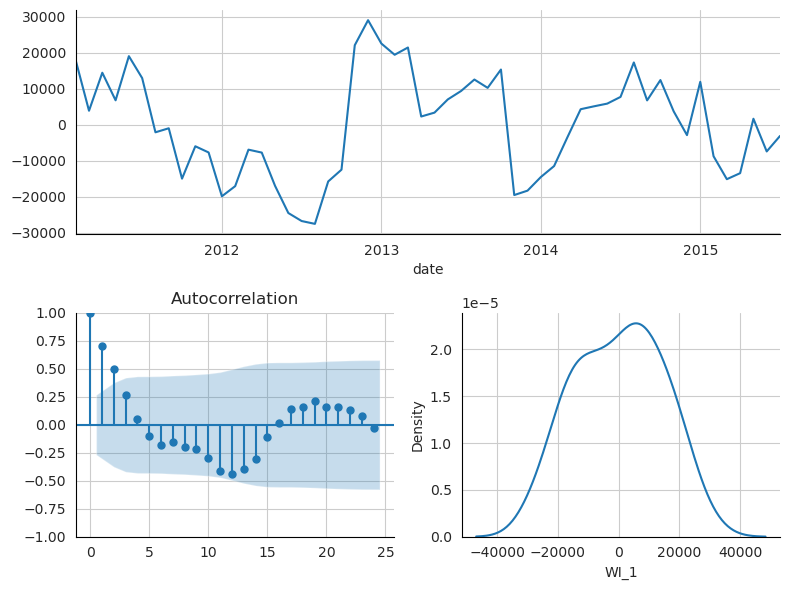



 Store Name WI_2

** Mean of the residuals:  0.69



** Ljung Box Test, p-value: 1.0700089743195333e-09 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.754 (>0.05, Normal)



** AD Fuller, p_value: 0.03838450831352769 (<0.05, Stationary)


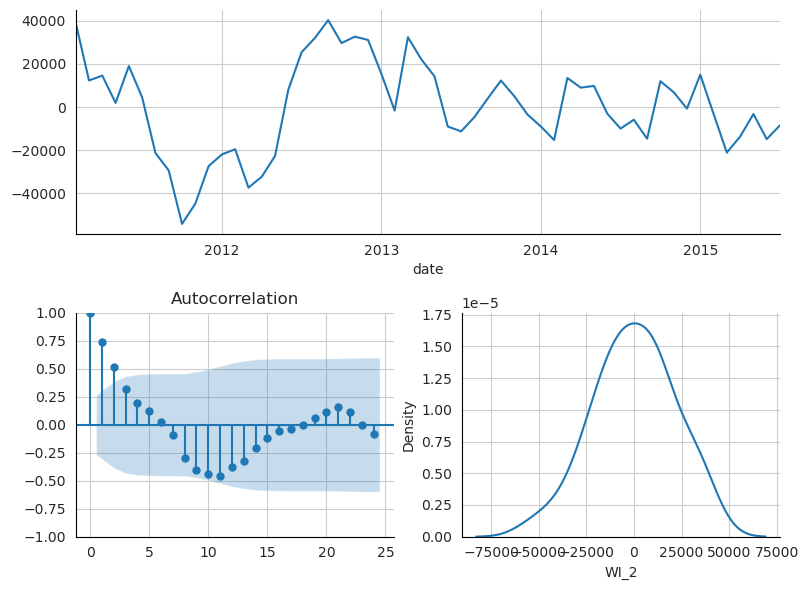



 Store Name WI_3

** Mean of the residuals:  0.19



** Ljung Box Test, p-value: 2.667517033702414e-12 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.168 (>0.05, Normal)



** AD Fuller, p_value: 0.034985010990305314 (<0.05, Stationary)


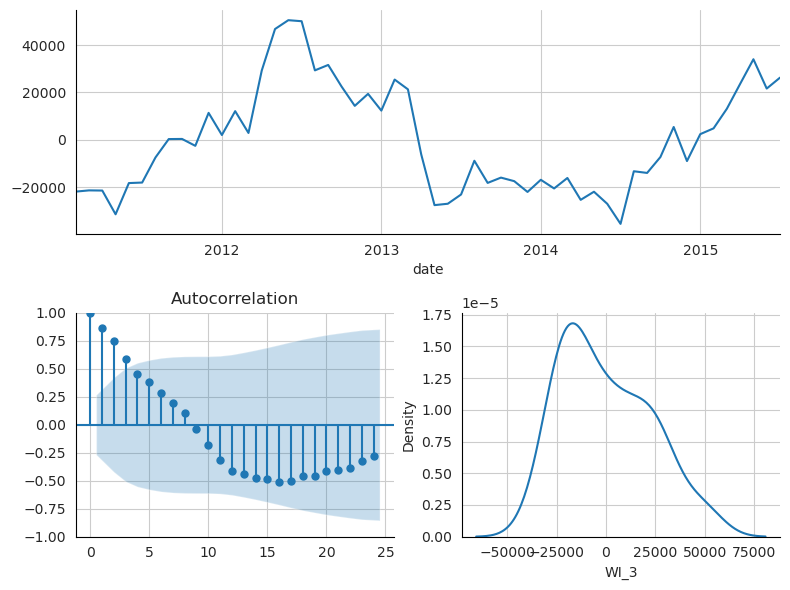

In [106]:
for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(resid_prophet_add["WI_"+str(i+1)],24);
    plt.show()



 Store Name WI_1

** Mean of the residuals:  -15.39



** Ljung Box Test, p-value: 1.5537766127532212e-09 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.534 (>0.05, Normal)



** AD Fuller, p_value: 0.03248201733352248 (<0.05, Stationary)


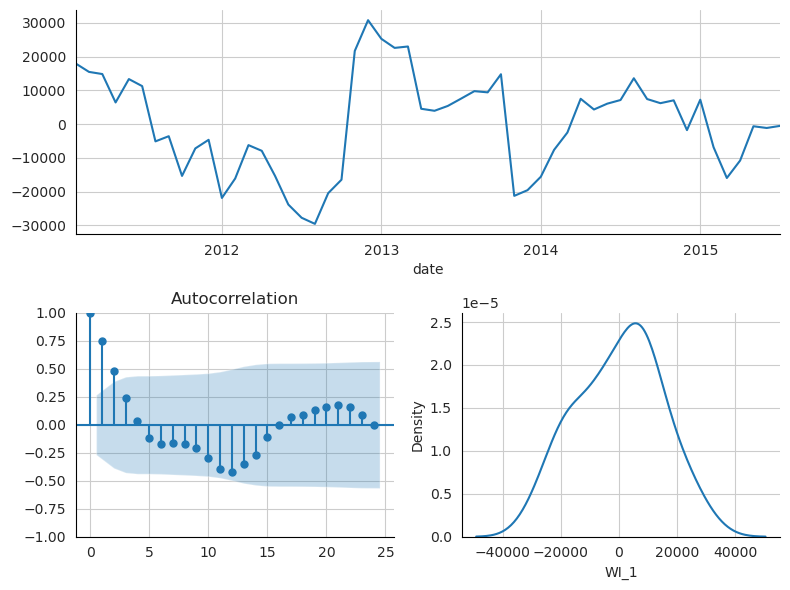



 Store Name WI_2

** Mean of the residuals:  -8.28



** Ljung Box Test, p-value: 2.2730718271405586e-10 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.634 (>0.05, Normal)



** AD Fuller, p_value: 0.030372609257023196 (<0.05, Stationary)


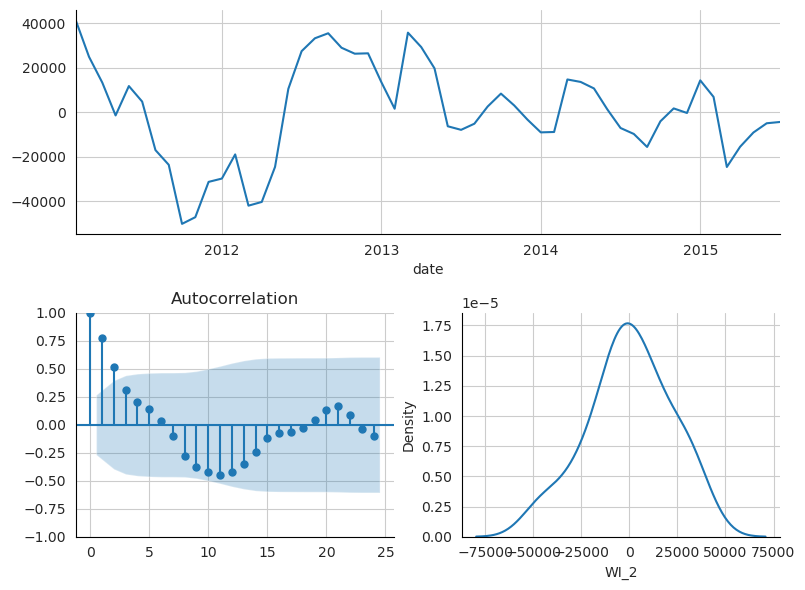



 Store Name WI_3

** Mean of the residuals:  -4.47



** Ljung Box Test, p-value: 2.3364421432403957e-12 (<0.05, Correlated)



** Jarque Bera Normality Test, p_value: 0.17 (>0.05, Normal)



** AD Fuller, p_value: 0.0368360703821798 (<0.05, Stationary)


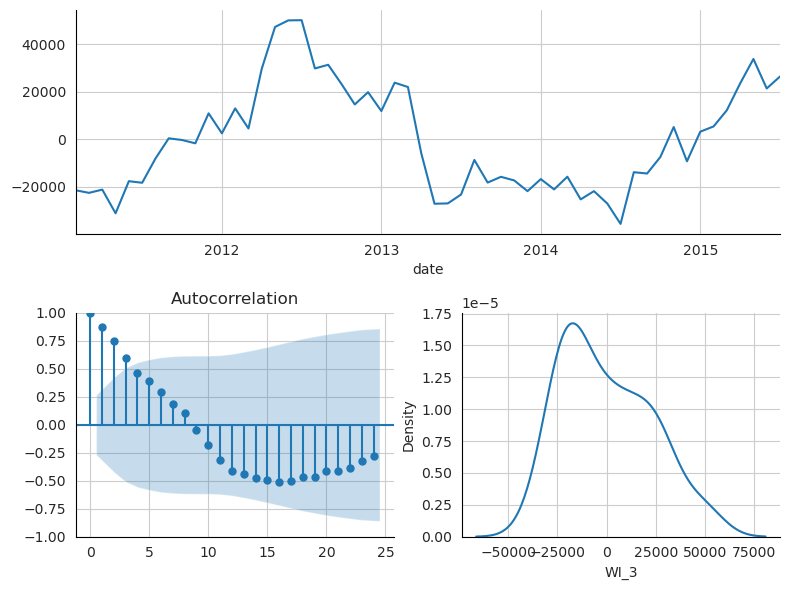

In [107]:
for i in range(len(store_list)):
    print("\n Store Name WI_"+str(i+1))
    residualcheck(resid_prophet_mul["WI_"+str(i+1)],24);
    plt.show()

### Summary Best Model

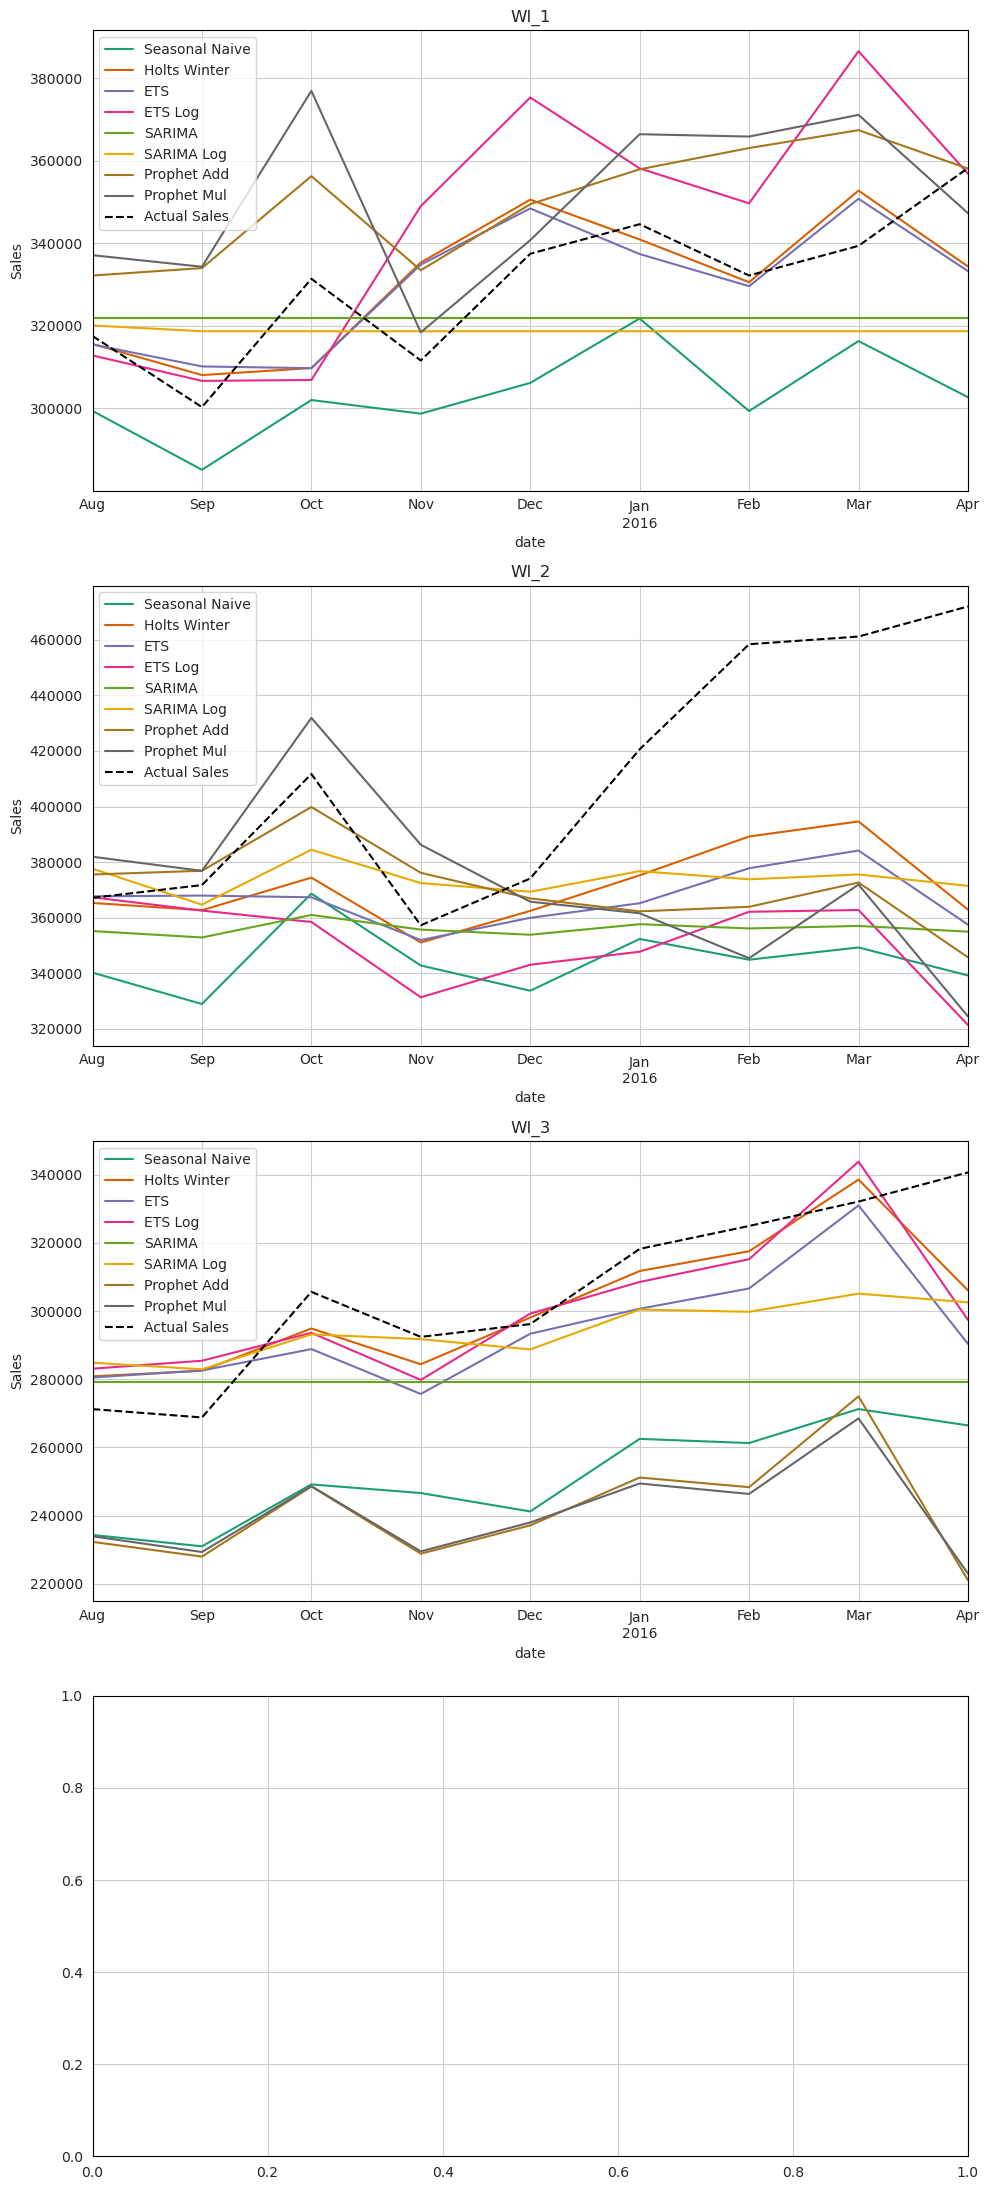

In [111]:
fig,axs=plt.subplots(figsize=(10,22),nrows=4,ncols=1)
for j,i in enumerate(store_list):   
    axs[j].set_prop_cycle(cycler('color', plt.cm.Dark2.colors))
    predicted_naive[i].plot(legend=True, label="Seasonal Naive",ax=axs[j]).set_title(i)
    predicted_HW[i].plot(legend=True, label="Holts Winter",ax=axs[j])
    predicted_ETS[i].plot(legend=True, label="ETS",ax=axs[j])
    predicted_ETSL[i].plot(legend=True, label="ETS Log",ax=axs[j])
    predicted_SARIMA[i].plot(legend=True, label="SARIMA",ax=axs[j])
    predicted_SARIMAL[i].plot(legend=True, label="SARIMA Log",ax=axs[j])
    predicted_prophet_add[i].plot(legend=True, label="Prophet Add",ax=axs[j])
    predicted_prophet_mul[i].plot(legend=True, label="Prophet Mul",ax=axs[j])
    Test[i].plot(color="black",label="Actual Sales",style="--",legend=True,ax=axs[j])
    axs[j].set_ylabel("Sales")
    axs[j].grid(which='minor')
fig.tight_layout()


In [112]:
Model_Performance.sort_values(by=["store_id","RMSE","MAPE"],inplace=True)
Model_Performance.set_index("store_id",inplace=True)

1. **WI_1**

In [113]:
Model_Performance.loc["WI_1"]

Forecast Method  MAPE     RMSE
store_id                                       
WI_1        Holts-Winter Box-Cox   3.7  15017.1
WI_1                         ETS   3.8  15062.7
WI_1                      SARIMA   4.9  18711.2
WI_1                  SARIMA Log   5.3  20416.9
WI_1            Prophet Additive   6.1  22368.9
WI_1                     ETS Log   6.4  26259.2
WI_1      Prophet Multiplicative   7.0  26666.7
WI_1              Seasonal Naive   8.0  29397.0

In [114]:
HW_model_best.loc["WI_1"]

Trend                        add
Seasonal                     add
Damped                      True
Box_Cox                     True
AICc_Train                1094.5
MAPE_Train                   4.6
RMSE_Train               14949.3
MAPE_Test                    3.7
RMSE_Test                15017.1
lj_residual         Uncorrelated
jb_norm_residual      Not Normal
resid_mean                 813.5
Name: WI_1, dtype: object

In [115]:
CA1_model=ExponentialSmoothing(np.log(CA_monthly["WI_1"]),
                     trend=HW_model_best.loc["WI_1"].Trend,
                     seasonal=HW_model_best.loc["WI_1"].Seasonal,
                     damped_trend=HW_model_best.loc["WI_1"].Damped,
                     seasonal_periods=12,
                     use_boxcox=False,
                     initialization_method="heuristic",
                     freq='MS').fit()
fit_CA1=np.exp(CA1_model.fittedvalues)
predicted_CA1=np.exp(CA1_model.forecast(6))
sim_frame_CA1=CA1_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [116]:
percentile_CA1=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA1.columns)
for i in sim_frame_CA1.columns:
    percentile_CA1.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA1[i],0.025).round(1)
    percentile_CA1.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA1[i],0.975).round(1) 

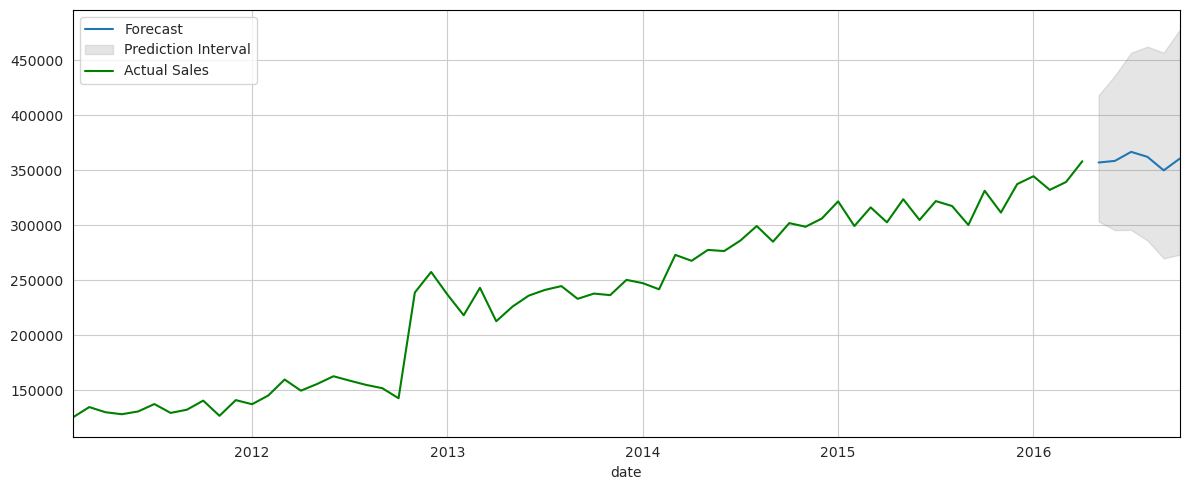

In [117]:
percentile_CA1["97.5th_percentile"]=percentile_CA1["97.5th_percentile"].astype(int)
percentile_CA1["2.5th_percentile"]=percentile_CA1["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA1.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA1.index,y1=percentile_CA1["2.5th_percentile"],y2=percentile_CA1["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["WI_1"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()

2. **WI_2**

In [118]:
Model_Performance.loc["WI_2"]

Forecast Method  MAPE     RMSE
store_id                                       
WI_2            Holts-Winter Log   8.9  52529.0
WI_2                  SARIMA Log   9.5  55459.0
WI_2                         ETS   9.9  58527.7
WI_2            Prophet Additive  10.5  63911.5
WI_2                      SARIMA  12.4  68681.9
WI_2      Prophet Multiplicative  12.2  72688.0
WI_2                     ETS Log  13.6  75655.2
WI_2              Seasonal Naive  15.3  77432.7

In [119]:
CA2_model=sm.tsa.statespace.ExponentialSmoothing(np.log(CA_monthly["WI_2"]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)
fit_CA2=np.exp(CA2_model.fittedvalues)
predicted_CA2=np.exp(CA2_model.forecast(6))
sim_frame_CA2=CA2_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [120]:
percentile_CA2=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA2.columns)
for i in sim_frame_CA2.columns:
    percentile_CA2.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA2[i],0.025).round(1)
    percentile_CA2.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA2[i],0.975).round(1) 

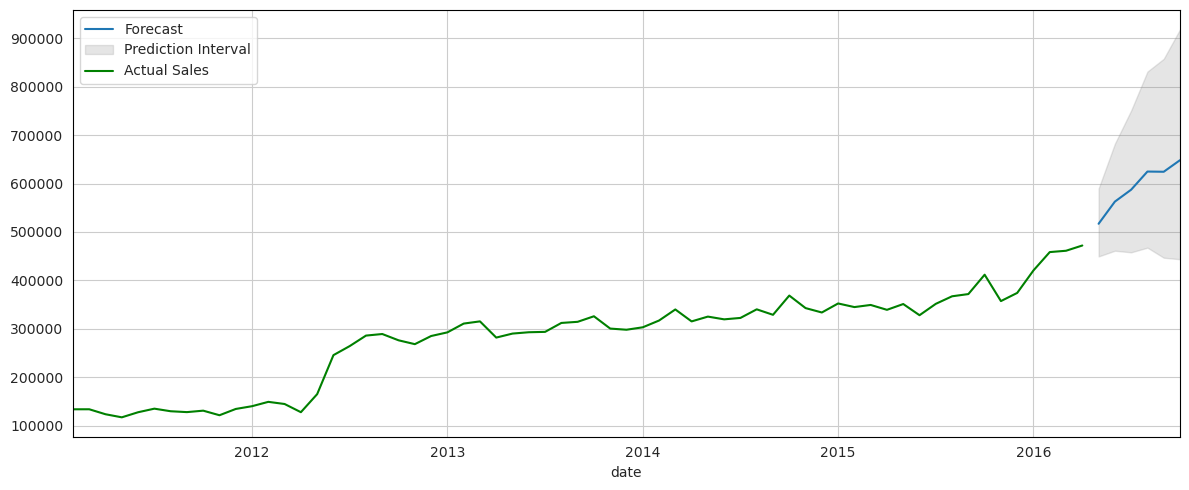

In [121]:
percentile_CA2["97.5th_percentile"]=percentile_CA2["97.5th_percentile"].astype(int)
percentile_CA2["2.5th_percentile"]=percentile_CA2["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA2.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA2.index,y1=percentile_CA2["2.5th_percentile"],y2=percentile_CA2["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["WI_2"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()

In [122]:
t1=CA2_model.get_forecast(6)
t2=t1.summary_frame(alpha=0.05).apply(np.exp)[["mean","mean_ci_lower","mean_ci_upper"]]

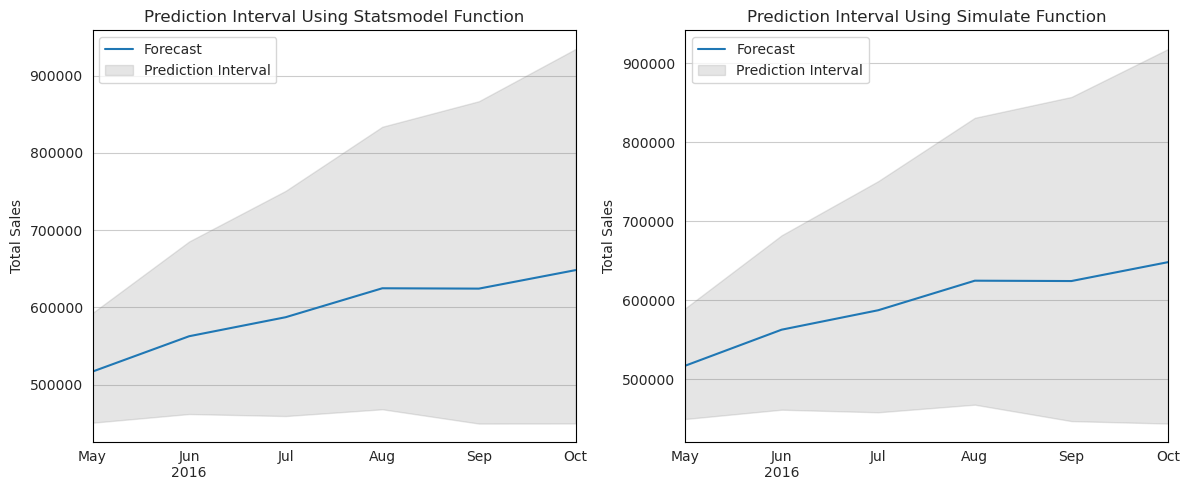

In [123]:
fig, (ax,ax2) = plt.subplots(figsize=(12,5),nrows=1,ncols=2)
predicted_CA2.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA2.index,y1=t2.mean_ci_lower,y2=t2.mean_ci_upper,label="Prediction Interval", alpha=0.2,color='gray')
ax.legend(loc="upper left")
ax.set_title("Prediction Interval Using Statsmodel Function")
ax.set_ylabel("Total Sales")
predicted_CA2.plot(ax=ax2, legend=True, label="Forecast" )
ax2.fill_between(percentile_CA2.index,y1=percentile_CA2["2.5th_percentile"],y2=percentile_CA2["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
ax2.legend(loc="upper left")
ax2.set_title("Prediction Interval Using Simulate Function")
ax2.set_ylabel("Total Sales")
fig.tight_layout()

3. **WI_3**

In [124]:
Model_Performance.loc["WI_3"]

Forecast Method  MAPE     RMSE
store_id                                       
WI_3            Holts-Winter Log   3.6  14140.9
WI_3                     ETS Log   4.7  18039.6
WI_3                  SARIMA Log   5.5  20355.0
WI_3                         ETS   5.2  21138.7
WI_3                      SARIMA   9.6  35862.7
WI_3              Seasonal Naive  17.5  55258.9
WI_3            Prophet Additive  20.8  68254.0
WI_3      Prophet Multiplicative  20.9  68605.1

In [125]:
print("Holts Winter AICc:",HW_model_best.loc["WI_3"].AICc_Train,"\nETS Log AICc:",ETSL_models[2].aicc)

Holts Winter AICc: -286.5 

ETS Log AICc: -162.99915224131377


In [126]:
CA3_model=sm.tsa.statespace.ExponentialSmoothing(np.log(CA_monthly["WI_3"]),
                                               trend=True, 
                                               initialization_method= 'heuristic', 
                                               seasonal=12, 
                                               damped_trend=False).fit(disp=0)
fit_CA3=np.exp(CA3_model.fittedvalues)
predicted_CA3=np.exp(CA3_model.forecast(6))
sim_frame_CA3=CA3_model.simulate(6, anchor='end',repetitions=5000 ).T.apply(np.exp).round(1)

In [127]:
percentile_CA3=pd.DataFrame(columns=["2.5th_percentile","97.5th_percentile"],index=sim_frame_CA3.columns)
for i in sim_frame_CA3.columns:
    percentile_CA3.loc[i,"2.5th_percentile"]=np.quantile(sim_frame_CA3[i],0.025).round(1)
    percentile_CA3.loc[i,"97.5th_percentile"]=np.quantile(sim_frame_CA3[i],0.975).round(1) 

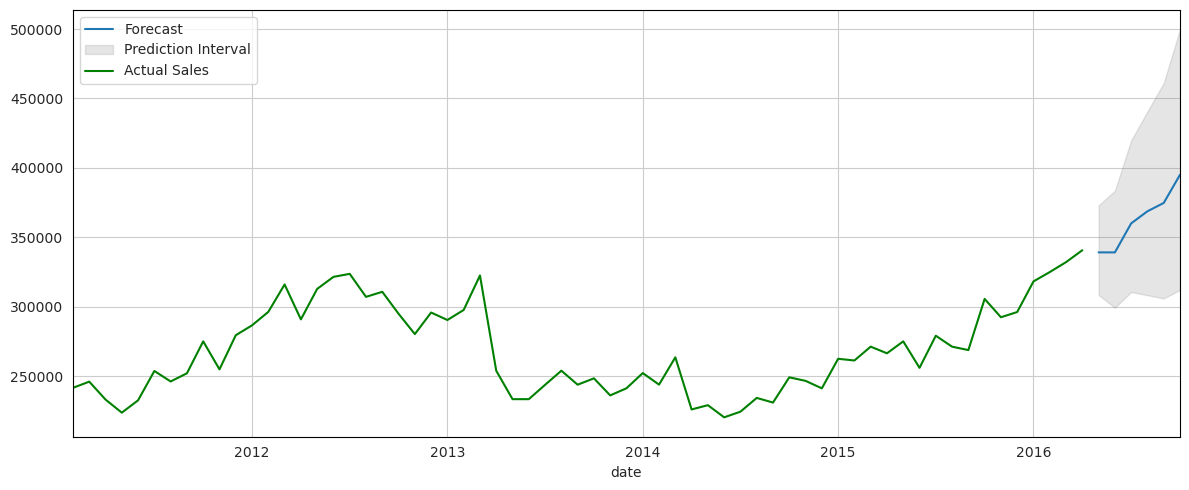

In [128]:
percentile_CA3["97.5th_percentile"]=percentile_CA3["97.5th_percentile"].astype(int)
percentile_CA3["2.5th_percentile"]=percentile_CA3["2.5th_percentile"].astype(int)
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=1)
predicted_CA3.plot(ax=ax, legend=True, label="Forecast" )
ax.fill_between(percentile_CA3.index,y1=percentile_CA3["2.5th_percentile"],y2=percentile_CA3["97.5th_percentile"],label="Prediction Interval", alpha=0.2,color='gray')
CA_monthly["WI_3"].plot(legend=True, label="Actual Sales",color="green", ax=ax);
ax.legend(loc="upper left")
fig.tight_layout()